# Credit Card Fraud Detection
Our data has already been processed using PCA and therefore only the 'amount' column needs to be scaled. We will use Variational Auto Encoders (VAE) and various ML models like XGBoost, CatBoost, SVM'S etc for classification.
We will also use undersampling and oversampling and compare the two methods.

In [1]:
# Only run these if they're not already installed
!pip install pytorch  
!pip install scikit-learn
!pip install imbalanced-learn  # for handling class imbalance
!pip install seaborn  # for visualization
!pip install catboost

  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (pytorch)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 99.2 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-le

In [2]:
# Data processing
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# For autoencoder (using PyTorch)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# For sampling techniques
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import (
    RandomUnderSampler,
    NearMiss,
    TomekLinks,
    ClusterCentroids,
    EditedNearestNeighbours
)
from imblearn.combine import SMOTETomek, SMOTEENN

# For evaluation metrics
from sklearn.metrics import (
    classification_report, 
    precision_recall_curve, 
    average_precision_score, 
    roc_auc_score,
    f1_score,
    confusion_matrix
)

# For model selection
from sklearn.model_selection import GridSearchCV, cross_val_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "creditcard.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "mlg-ulb/creditcardfraud",
  file_path,
  # Provide any additional arguments like 
  # sql_query or pandas_kwargs. See the 
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:", df.head())

/tmp/ipykernel_31/1581108097.py:10: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(


First 5 records:    Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26    

In [4]:
df.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


In [5]:
def check_data_quality(df):
    """
    Check a DataFrame for:
    - Missing values (count and percentage)
    - Data types (especially object types)
    - String values in columns
    
    Args:
        df: pandas DataFrame to analyze
    
    Returns:
        Prints a comprehensive report and returns a summary DataFrame
    """
    # Total rows
    total_rows = len(df)
    
    # Missing values analysis
    missing_values = df.isnull().sum()
    missing_percentage = (missing_values / total_rows * 100).round(2)
    
    # Data types
    dtypes = df.dtypes
    
    # Check for string values in each column
    contains_strings = []
    for col in df.columns:
        if df[col].dtype == 'object':
            contains_strings.append(True)
        else:
            # Check if any numeric column contains strings
            try:
                df[col].astype(float)
                contains_strings.append(False)
            except:
                contains_strings.append(True)
    
    # Create summary DataFrame
    summary_df = pd.DataFrame({
        'Data Type': dtypes,
        'Missing Values': missing_values,
        'Missing Percentage': missing_percentage,
        'Contains Strings': contains_strings,
        'Is Object Type': dtypes == 'object'
    })
    
    # Print report
    print(f"Dataset has {total_rows} rows and {len(df.columns)} columns.")
    
    if missing_values.sum() > 0:
        print(f"\nMissing values found in {missing_values[missing_values > 0].count()} columns.")
        for col in missing_values[missing_values > 0].index:
            print(f"  - {col}: {missing_values[col]} values missing ({missing_percentage[col]}%)")
    else:
        print("\nNo missing values found.")
    
    object_cols = dtypes[dtypes == 'object'].index.tolist()
    if object_cols:
        print(f"\nObject type columns ({len(object_cols)}):")
        for col in object_cols:
            print(f"  - {col}")
    
    string_cols = [col for col, has_str in zip(df.columns, contains_strings) if has_str]
    if string_cols:
        print(f"\nColumns containing strings ({len(string_cols)}):")
        for col in string_cols:
            print(f"  - {col}")
    
    # Return the summary DataFrame
    return summary_df


# Check data quality
data_summary = check_data_quality(df)

# Display the summary dataframe
print("\nDetailed Summary:")
display(data_summary)

Dataset has 284807 rows and 31 columns.

No missing values found.

Detailed Summary:


,Data Type,Missing Values,Missing Percentage,Contains Strings,Is Object Type
Time,float64,0,0.0,False,False
V1,float64,0,0.0,False,False
V2,float64,0,0.0,False,False
V3,float64,0,0.0,False,False
V4,float64,0,0.0,False,False
V5,float64,0,0.0,False,False
V6,float64,0,0.0,False,False
V7,float64,0,0.0,False,False
V8,float64,0,0.0,False,False
V9,float64,0,0.0,False,False


### EDA

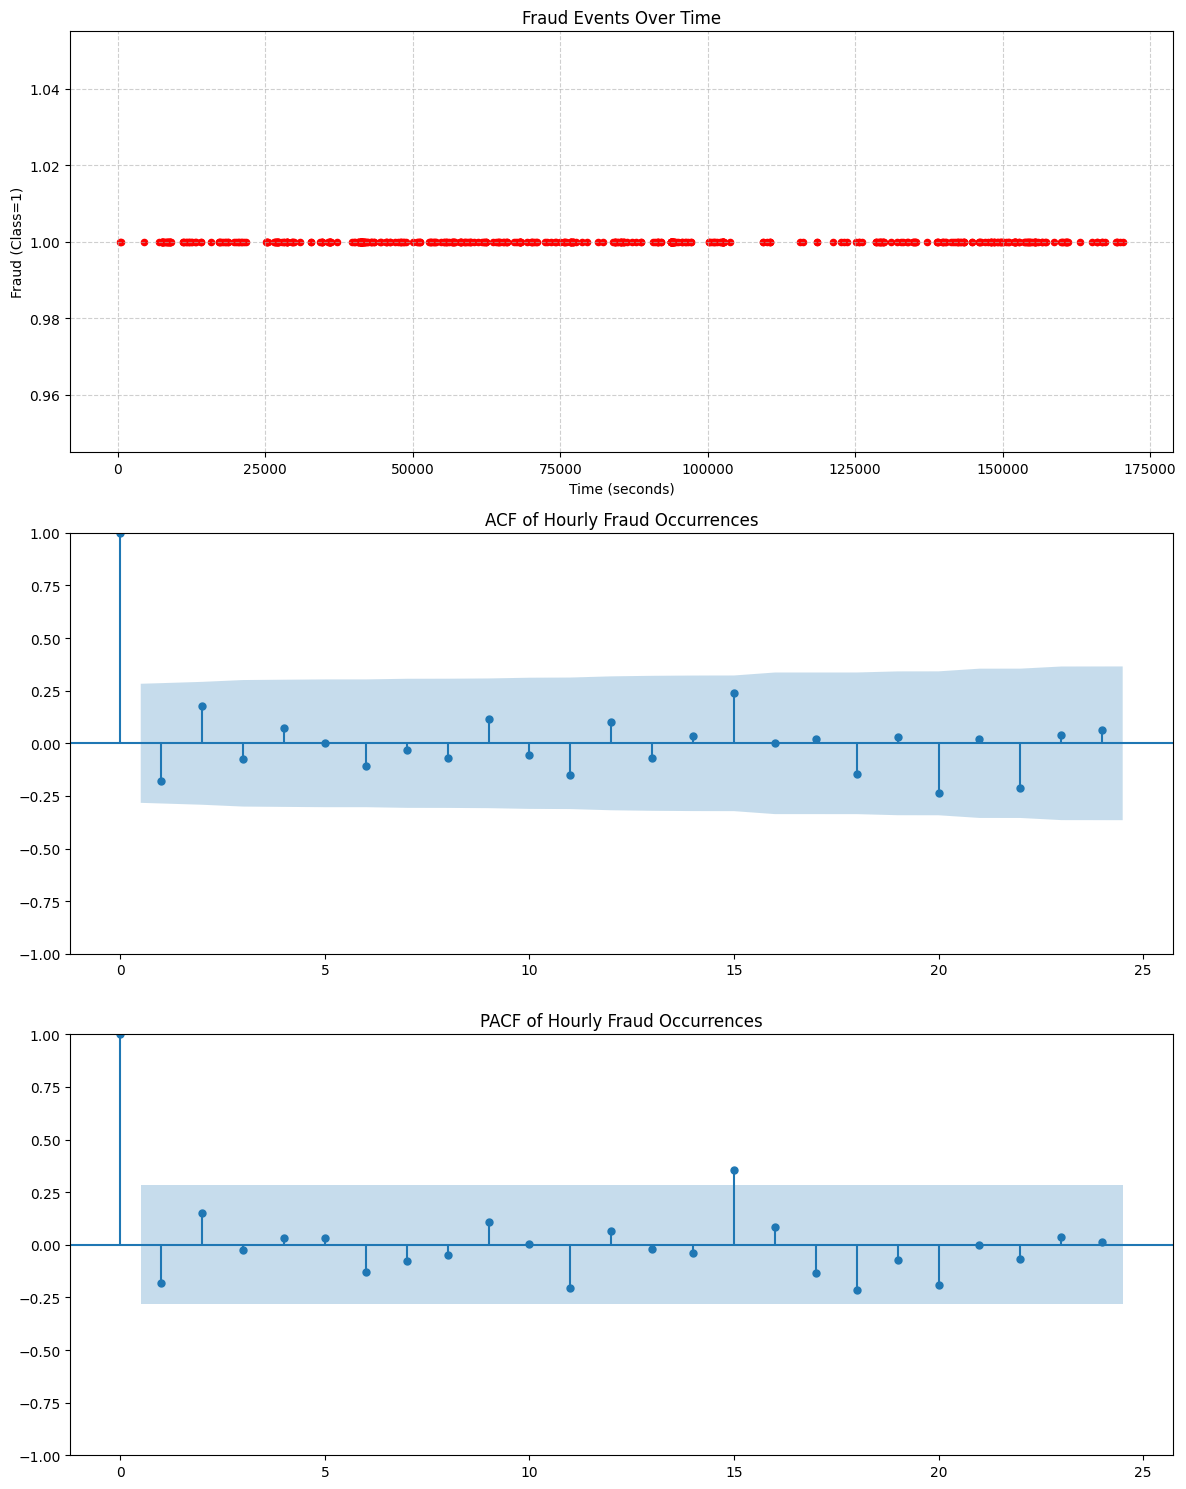

/tmp/ipykernel_31/1769044326.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fraud['hour_of_day'] = (df_fraud['Time'] / 3600) % 24


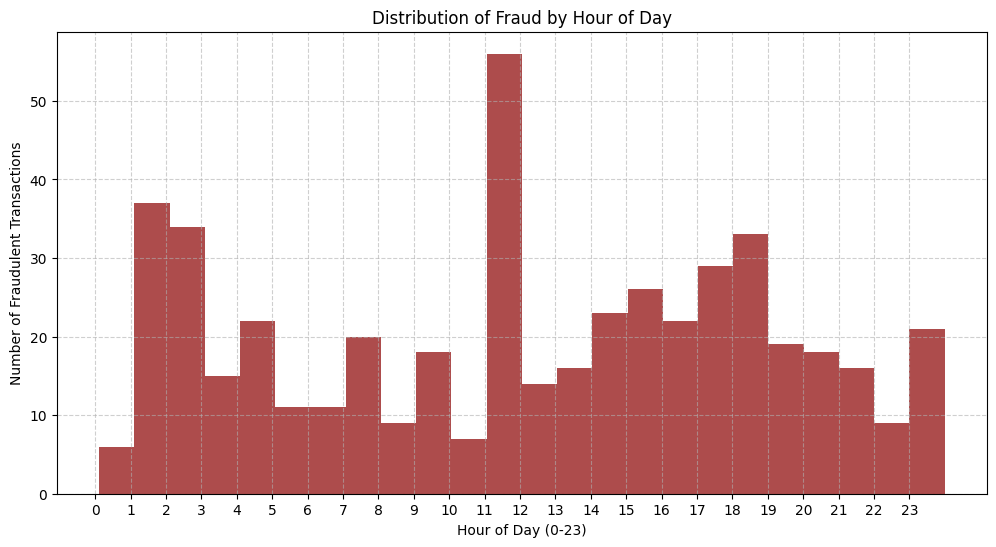

Total fraudulent transactions: 492


In [6]:
df_fraud = df[df['Class']==1]

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Extract only fraud cases
df_fraud = df[df['Class'] == 1]

# Create figure for plotting
fig, axes = plt.subplots(3, 1, figsize=(12, 15))

# Plot 1: Fraud events over time (simple scatter plot)
axes[0].scatter(df_fraud['Time'], df_fraud['Class'], color='red', s=20)
axes[0].set_title('Fraud Events Over Time')
axes[0].set_xlabel('Time (seconds)')
axes[0].set_ylabel('Fraud (Class=1)')
axes[0].grid(True, linestyle='--', alpha=0.6)

# For ACF/PACF, we need to bin the data since fraud events aren't evenly spaced
# Create time bins (e.g., hourly)
bin_size = 3600  # 1 hour in seconds
max_time = df['Time'].max()
bins = np.arange(0, max_time + bin_size, bin_size)

# Count frauds in each bin
fraud_counts = pd.Series(0, index=range(len(bins)-1))
for t in df_fraud['Time']:
    bin_idx = int(t // bin_size)
    if bin_idx < len(fraud_counts):
        fraud_counts[bin_idx] += 1

# Plot 2: ACF
plot_acf(fraud_counts, lags=24, ax=axes[1])
axes[1].set_title('ACF of Hourly Fraud Occurrences')

# Plot 3: PACF
plot_pacf(fraud_counts, lags=24, ax=axes[2])
axes[2].set_title('PACF of Hourly Fraud Occurrences')

plt.tight_layout()
plt.show()

# Additional visualization: Distribution of frauds by hour of day
plt.figure(figsize=(12, 6))
df_fraud['hour_of_day'] = (df_fraud['Time'] / 3600) % 24
plt.hist(df_fraud['hour_of_day'], bins=24, color='darkred', alpha=0.7)
plt.title('Distribution of Fraud by Hour of Day')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Number of Fraudulent Transactions')
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print(f"Total fraudulent transactions: {len(df_fraud)}")

In [7]:
# Takes some time so you can skip
# import numpy as np

# # Add hour of day to the full dataset first
# df['hour_of_day'] = (df['Time'] / 3600) % 24

# # Create stratified sample (to maintain fraud proportions)
# # For efficiency, include ALL fraud cases (since they're rare) and sample non-fraud cases
# fraud_sample = df[df['Class'] == 1]  # Keep all fraud cases
# non_fraud_sample = df[df['Class'] == 0].sample(n=min(10000, len(df[df['Class'] == 0])), random_state=42)  # Sample from non-fraud

# # Combine into a smaller dataset
# sample_df = pd.concat([fraud_sample, non_fraud_sample]).sort_values('Time')

# print(f"Original dataset size: {len(df)} transactions")
# print(f"Sample dataset size: {len(sample_df)} transactions")
# print(f"Fraud cases in sample: {len(sample_df[sample_df['Class'] == 1])} (100% of original fraud)")
# print(f"Original fraud rate: {df['Class'].mean():.6f}")
# print(f"Sample fraud rate: {sample_df['Class'].mean():.6f}")

# # Calculate fraud rate by hour from the sample
# hourly_fraud_rate = sample_df.groupby('hour_of_day')['Class'].mean()
# hourly_counts = sample_df.groupby('hour_of_day').size()

# # Create figure with two subplots
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# # Plot fraud rate by hour
# hourly_fraud_rate.plot(kind='bar', ax=ax1, color='darkred')
# ax1.set_title('Fraud Rate by Hour of Day (from Sample)')
# ax1.set_xlabel('Hour')
# ax1.set_ylabel('Fraud Rate (proportion)')
# ax1.grid(axis='y', linestyle='--', alpha=0.7)

# # Plot transaction count by hour
# hourly_counts.plot(kind='bar', ax=ax2, color='navy')
# ax2.set_title('Transaction Count by Hour of Day (from Sample)')
# ax2.set_xlabel('Hour')
# ax2.set_ylabel('Number of Transactions')
# ax2.grid(axis='y', linestyle='--', alpha=0.7)

# plt.tight_layout()
# plt.show()

# # Print hours with highest fraud rates
# print("Top 5 hours with highest fraud rates:")
# print(hourly_fraud_rate.sort_values(ascending=False).head(5))

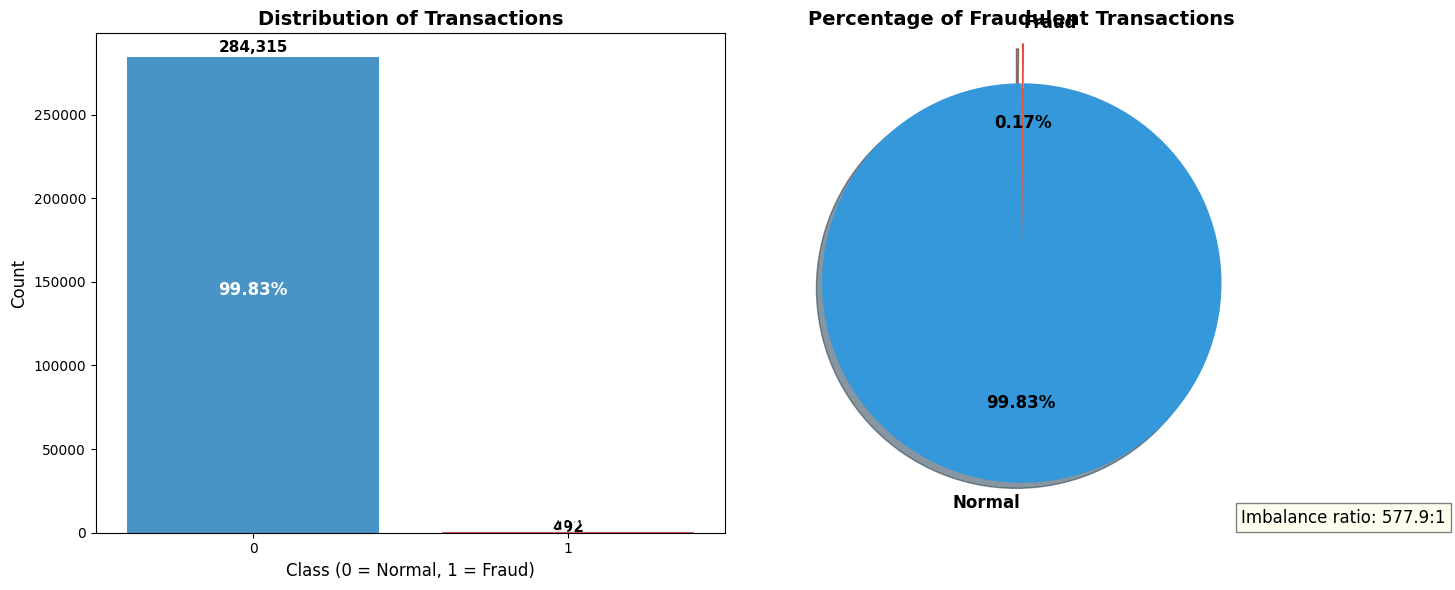

Class distribution summary:
Normal transactions (Class 0): 284,315 (99.8273%)
Fraud transactions (Class 1): 492 (0.1727%)

Class imbalance: 577.88:1 (Normal:Fraud)


In [8]:
def plot_distribution(df, class_column='Class'):
    """
    Plot the distribution of fraud vs. legitimate transactions with percentages.
    
    Args:
        df: pandas DataFrame containing the data
        class_column: column name containing the target variable (default: 'Class')
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Count values and calculate percentages
    value_counts = df[class_column].value_counts()
    percentages = value_counts / len(df) * 100
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Bar chart with counts and percentages
    sns.barplot(x=value_counts.index, y=value_counts.values, palette=['#3498db', '#e74c3c'], ax=ax1)
    ax1.set_title('Distribution of Transactions', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Class (0 = Normal, 1 = Fraud)', fontsize=12)
    ax1.set_ylabel('Count', fontsize=12)
    
    # Add count labels on bars
    for i, count in enumerate(value_counts.values):
        ax1.text(i, count + (count * 0.01), f'{count:,}', ha='center', fontsize=11, fontweight='bold')
    
    # Add percentage labels
    for i, (count, pct) in enumerate(zip(value_counts.values, percentages)):
        ax1.text(i, count / 2, f'{pct:.2f}%', ha='center', fontsize=12, fontweight='bold', color='white')
    
    # Plot 2: Pie chart with percentages
    ax2.pie(value_counts, labels=['Normal', 'Fraud'], autopct='%1.2f%%', 
            colors=['#3498db', '#e74c3c'], explode=[0, 0.2], shadow=True, startangle=90,
            textprops={'fontsize': 12, 'fontweight': 'bold'})
    ax2.set_title('Percentage of Fraudulent Transactions', fontsize=14, fontweight='bold')
    
    # Add annotation about imbalance
    imbalance_ratio = value_counts[0] / value_counts[1]
    ax2.text(1.1, -1.2, f"Imbalance ratio: {imbalance_ratio:.1f}:1", 
             fontsize=12, bbox=dict(facecolor='lightyellow', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"Class distribution summary:")
    for i, (count, pct) in enumerate(zip(value_counts.values, percentages)):
        label = 'Normal' if i == 0 else 'Fraud'
        print(f"{label} transactions (Class {i}): {count:,} ({pct:.4f}%)")
    
    print(f"\nClass imbalance: {imbalance_ratio:.2f}:1 (Normal:Fraud)")

# Use the function
plot_distribution(df)

### Data Pre-processing
Drop Time -> Original 80/20 split (stratify=y) -> Further 80/20 split where y=0 (non fraudulent) -> Feed train(y=0) in Auto-Encoder and evaluate -> calculate reconstruction error for all data -> add it as feature -> Create balanced dataset from the training portion -> feed in classification algorithms -> Evaluate using test dataset.

In [9]:
# If you skiped "hour_of_day" wont exist in the df
y = df['Class']

# X = df.drop(['Time','Class','hour_of_day'], axis=1)
X = df.drop(['Time','Class'], axis=1)
X.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


In [10]:
# Stratified split to maintain fraud distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # This ensures proportional distribution
)

scaler = StandardScaler()

# fit on only one column
scaler.fit(X_train[['Amount']])

# transform column in each split
for df in [X_train, X_test]:
    df[['Amount']] = scaler.transform(df[['Amount']])
    
# Extract legitimate transactions for autoencoder training
X_train_legitimate = X_train[y_train == 0]
X_train_legitimate, X_val_legitimate = train_test_split(
    X_train_legitimate, 
    test_size=0.2, 
    random_state=42
)

### Variational Auto Encoder

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Convert to PyTorch tensors
X_train_legitimate_tensor = torch.FloatTensor(X_train_legitimate.values).to(device)
X_val_legitimate_tensor = torch.FloatTensor(X_val_legitimate.values).to(device)
X_train_tensor = torch.FloatTensor(X_train.values).to(device)
X_test_tensor = torch.FloatTensor(X_test.values).to(device)

# Create DataLoaders
train_dataset = TensorDataset(X_train_legitimate_tensor, X_train_legitimate_tensor)
val_dataset = TensorDataset(X_val_legitimate_tensor, X_val_legitimate_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# Get input dimensions
input_dim = X_train_legitimate.shape[1]
print(f"Input dimension: {input_dim}")

Using device: cuda
Input dimension: 29


VAE(
  (encoder): Sequential(
    (0): Linear(in_features=29, out_features=24, bias=True)
    (1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Linear(in_features=24, out_features=16, bias=True)
    (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1)
  )
  (fc_mu): Linear(in_features=16, out_features=6, bias=True)
  (fc_var): Linear(in_features=16, out_features=6, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=6, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Linear(in_features=16, out_features=24, bias=True)
    (4): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1)
    (6): Linear(in_features=24, out_features=29, bias=True)
  )
)
E

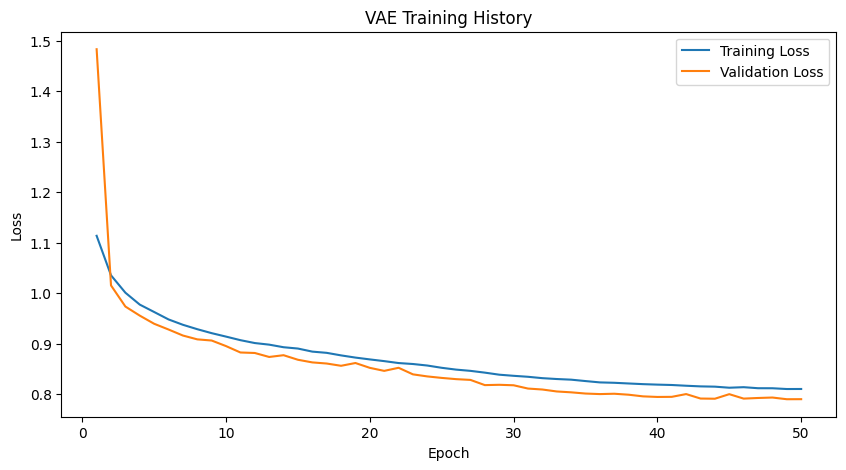

In [12]:
# VAE Model
class VAE(nn.Module):
    def __init__(self, input_dim=29, latent_dim=10, beta=0.1):
        super(VAE, self).__init__()
        
        # Encoder - gradually reducing dimensions
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 24),
            nn.BatchNorm1d(24),
            nn.LeakyReLU(0.1),
            nn.Linear(24, 16),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.1)
        )
        
        # Latent space
        self.fc_mu = nn.Linear(16, latent_dim)
        self.fc_var = nn.Linear(16, latent_dim)
        self.beta = beta  # Lower beta to focus more on reconstruction
        
        # Decoder - gradually increasing dimensions
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.1),
            nn.Linear(16, 24),
            nn.BatchNorm1d(24),
            nn.LeakyReLU(0.1),
            nn.Linear(24, input_dim)
        )
        
    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var
    
    def get_reconstruction_error(self, x):
        # Switched to no_grad() mode for inference
        with torch.no_grad():
            x_reconstructed, mu, log_var = self(x)
            # Mean squared error per sample
            reconstruction_error = torch.mean((x - x_reconstructed)**2, dim=1)
        return reconstruction_error

# Create the model
vae = VAE(input_dim=input_dim, latent_dim=6).to(device)
print(vae)

# Loss Function and Optimizer
def vae_loss_function(x_reconstructed, x, mu, log_var, beta=0.1):
    # Reconstruction loss (MSE)
    recon_loss = torch.mean((x - x_reconstructed)**2, dim=1)
    
    # KL Divergence loss with reduced weight (beta)
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1)
    
    # Total loss with beta parameter
    total_loss = torch.mean(recon_loss + beta * kl_loss)
    
    return total_loss, torch.mean(recon_loss), torch.mean(kl_loss)

optimizer = optim.Adam(vae.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-5
)

# Training Function
def train_epoch(model, train_loader, optimizer):
    model.train()
    train_loss = 0
    recon_loss_total = 0
    kl_loss_total = 0
    
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        reconstructed, mu, log_var = model(data)
        loss, recon_loss, kl_loss = vae_loss_function(reconstructed, data, mu, log_var)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        recon_loss_total += recon_loss.item()
        kl_loss_total += kl_loss.item()
    
    return train_loss / len(train_loader), recon_loss_total / len(train_loader), kl_loss_total / len(train_loader)

# Validation Function
def validate(model, val_loader):
    model.eval()
    val_loss = 0
    recon_loss_total = 0
    kl_loss_total = 0
    
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(val_loader):
            reconstructed, mu, log_var = model(data)
            loss, recon_loss, kl_loss = vae_loss_function(reconstructed, data, mu, log_var)
            
            val_loss += loss.item()
            recon_loss_total += recon_loss.item()
            kl_loss_total += kl_loss.item()
    
    return val_loss / len(val_loader), recon_loss_total / len(val_loader), kl_loss_total / len(val_loader)

# Training Loop
n_epochs = 50
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience = 10
patience_counter = 0

for epoch in range(n_epochs):
    train_loss, train_recon, train_kl = train_epoch(vae, train_loader, optimizer)
    val_loss, val_recon, val_kl = validate(vae, val_loader)

    # Update learning rate based on validation loss
    scheduler.step(val_loss)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = vae.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, Train Recon: {train_recon:.6f}, Train KL: {train_kl:.6f}")

# Load best model
vae.load_state_dict(best_model_state)

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Training History')
plt.legend()
plt.show()

### Add new feature from Auto-Encoder

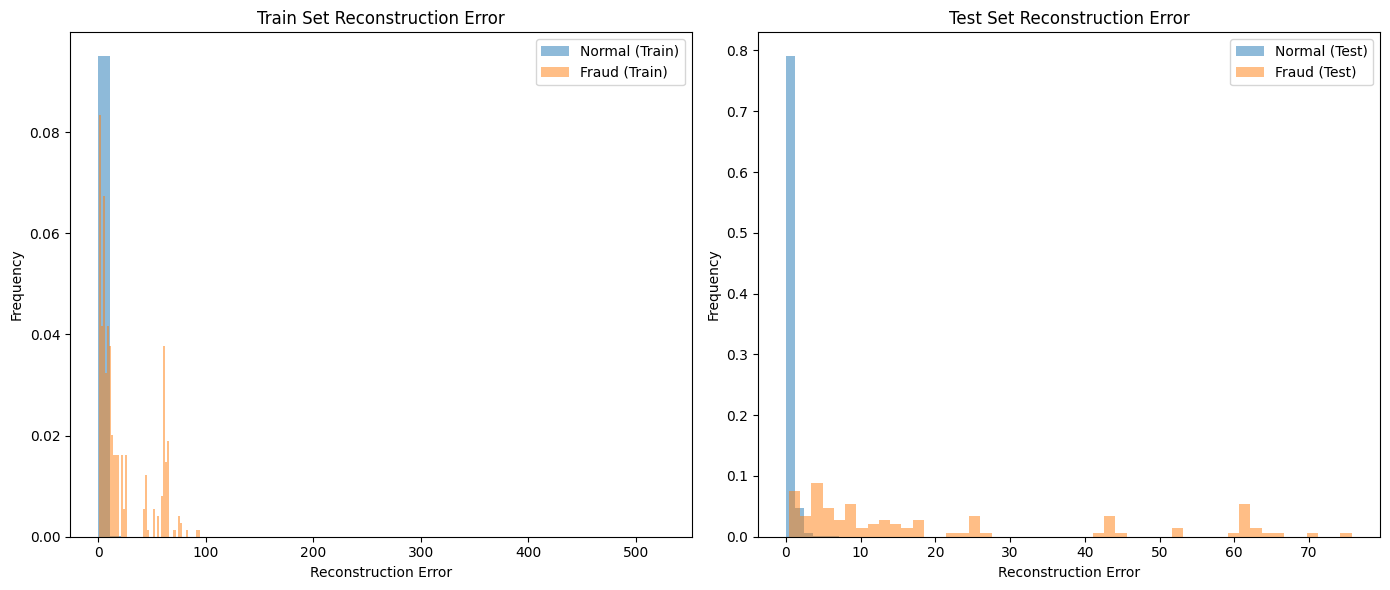

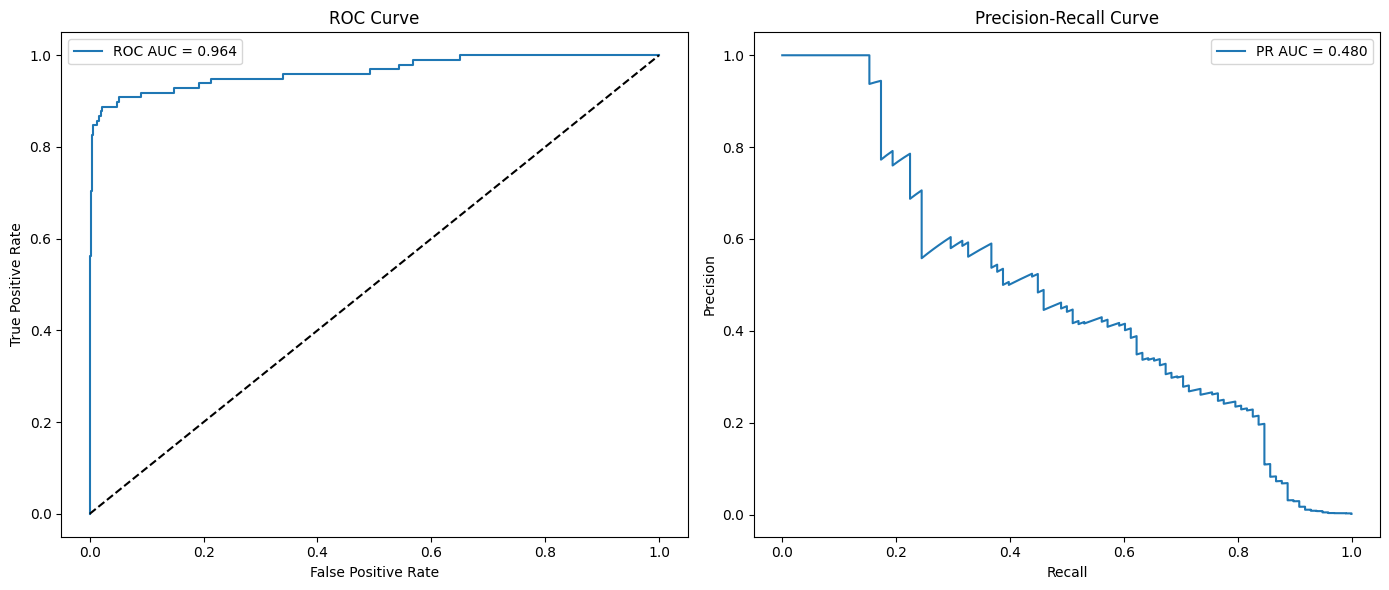

Reconstruction error statistics:
Normal transactions (mean ± std): 0.6443 ± 0.9808
Fraud transactions (mean ± std): 20.7165 ± 22.0204
Difference: 20.0722


In [13]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Calculate reconstruction errors for all data
vae.eval()
with torch.no_grad():
    train_errors = vae.get_reconstruction_error(X_train_tensor).cpu().numpy()
    test_errors = vae.get_reconstruction_error(X_test_tensor).cpu().numpy()

# Visualize reconstruction error distribution
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(train_errors[y_train == 0], bins=50, alpha=0.5, label='Normal (Train)', density=True)
plt.hist(train_errors[y_train == 1], bins=50, alpha=0.5, label='Fraud (Train)', density=True)
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Train Set Reconstruction Error')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(test_errors[y_test == 0], bins=50, alpha=0.5, label='Normal (Test)', density=True)
plt.hist(test_errors[y_test == 1], bins=50, alpha=0.5, label='Fraud (Test)', density=True)
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Test Set Reconstruction Error')
plt.legend()

plt.tight_layout()
plt.show()

# Performance evaluation with ROC and Precision-Recall curves
fpr, tpr, thresholds = roc_curve(y_test, test_errors)
roc_auc = auc(fpr, tpr)

precision, recall, thresholds = precision_recall_curve(y_test, test_errors)
pr_auc = auc(recall, precision)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.tight_layout()
plt.show()

# Print statistics and prepare data for hybrid model
print("Reconstruction error statistics:")
print(f"Normal transactions (mean ± std): {np.mean(test_errors[y_test == 0]):.4f} ± {np.std(test_errors[y_test == 0]):.4f}")
print(f"Fraud transactions (mean ± std): {np.mean(test_errors[y_test == 1]):.4f} ± {np.std(test_errors[y_test == 1]):.4f}")
print(f"Difference: {np.mean(test_errors[y_test == 1]) - np.mean(test_errors[y_test == 0]):.4f}")

### Undersampling

In [14]:
# Add reconstruction error as feature for classification
X_train_with_re = np.column_stack([X_train, train_errors])
X_test_with_re = np.column_stack([X_test, test_errors])

# Apply undersampling to the training data for classification
undersampler = RandomUnderSampler(sampling_strategy=1.0, random_state=42)  # 1:1 ratio
X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train_with_re, y_train)

# Print summary statistics
print("\nOriginal dataset:")
print(f"Training: {X_train.shape[0]} samples, {sum(y_train == 1)} frauds ({sum(y_train == 1)/len(y_train)*100:.2f}%)")
print(f"Testing: {X_test.shape[0]} samples, {sum(y_test == 1)} frauds ({sum(y_test == 1)/len(y_test)*100:.2f}%)")

print("\nBalanced training set after undersampling:")
print(f"Samples: {X_train_balanced.shape[0]}, {sum(y_train_balanced == 1)} frauds ({sum(y_train_balanced == 1)/len(y_train_balanced)*100:.2f}%)")

print("\nReconstruction error statistics:")
print(f"Normal transactions (mean ± std): {np.mean(test_errors[y_test == 0]):.4f} ± {np.std(test_errors[y_test == 0]):.4f}")
print(f"Fraud transactions (mean ± std): {np.mean(test_errors[y_test == 1]):.4f} ± {np.std(test_errors[y_test == 1]):.4f}")
print(f"Difference: {np.mean(test_errors[y_test == 1]) - np.mean(test_errors[y_test == 0]):.4f}")


Original dataset:
Training: 227845 samples, 394 frauds (0.17%)
Testing: 56962 samples, 98 frauds (0.17%)

Balanced training set after undersampling:
Samples: 788, 394 frauds (50.00%)

Reconstruction error statistics:
Normal transactions (mean ± std): 0.6443 ± 0.9808
Fraud transactions (mean ± std): 20.7165 ± 22.0204
Difference: 20.0722


### Classification on new Dataset


Training Random Forest...
Random Forest - Accuracy: 0.9626, Precision: 0.0403, Recall: 0.9082, F1: 0.0772
Random Forest - ROC AUC: 0.9755, PR AUC: 0.7468, Avg Precision: 0.6851
Random Forest - Training time: 0.33s, Testing time: 0.46s

Training XGBoost...
XGBoost - Accuracy: 0.9505, Precision: 0.0310, Recall: 0.9184, F1: 0.0601
XGBoost - ROC AUC: 0.9688, PR AUC: 0.4506, Avg Precision: 0.4548
XGBoost - Training time: 0.09s, Testing time: 0.10s

Training Logistic Regression...
Logistic Regression - Accuracy: 0.9580, Precision: 0.0363, Recall: 0.9184, F1: 0.0699
Logistic Regression - ROC AUC: 0.9742, PR AUC: 0.6650, Avg Precision: 0.6164
Logistic Regression - Training time: 0.19s, Testing time: 0.01s

Training SVM...
SVM - Accuracy: 0.9847, Precision: 0.0917, Recall: 0.8878, F1: 0.1662
SVM - ROC AUC: 0.9781, PR AUC: 0.6130, Avg Precision: 0.6068
SVM - Training time: 0.04s, Testing time: 1.25s

Training CatBoost...
CatBoost - Accuracy: 0.9645, Precision: 0.0428, Recall: 0.9184, F1: 0.0817

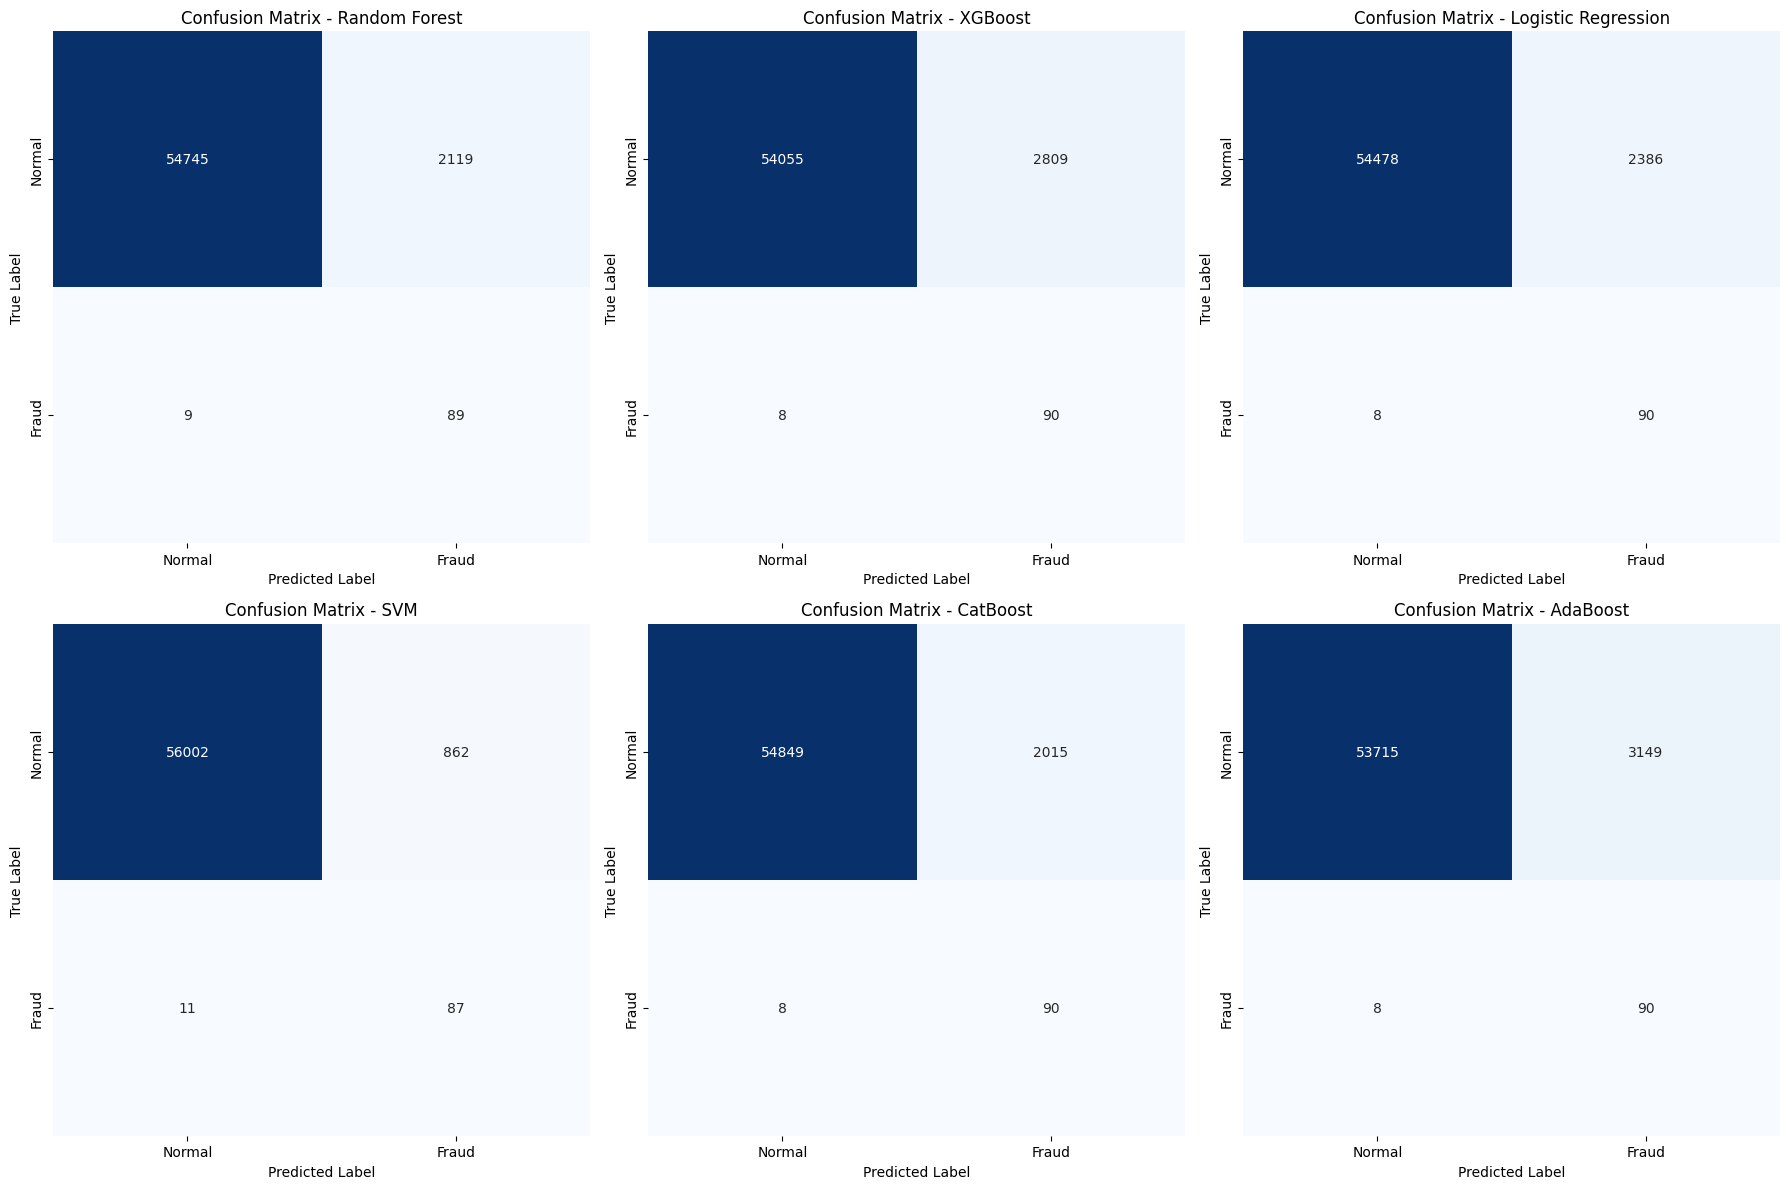

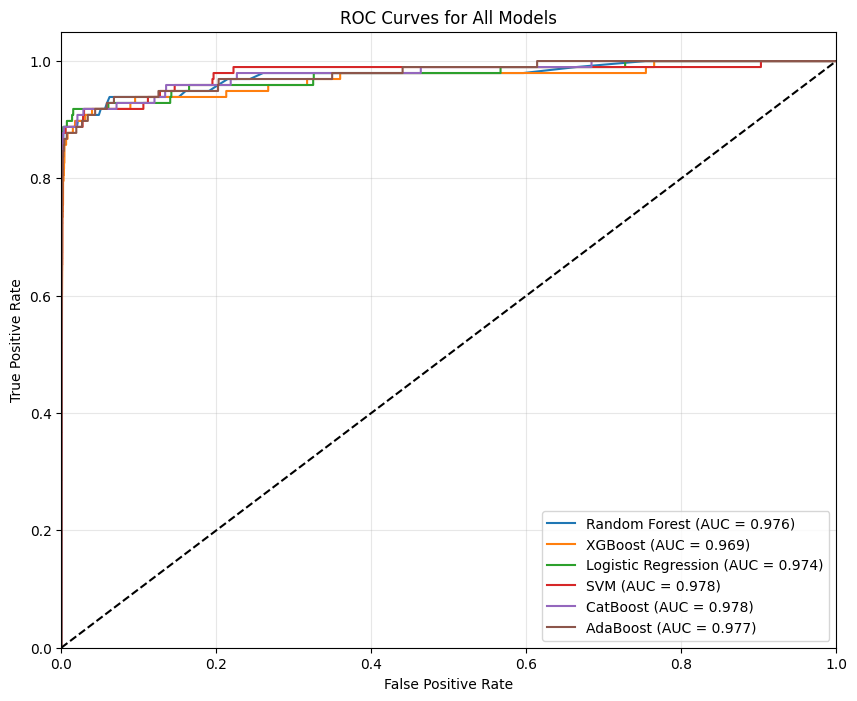

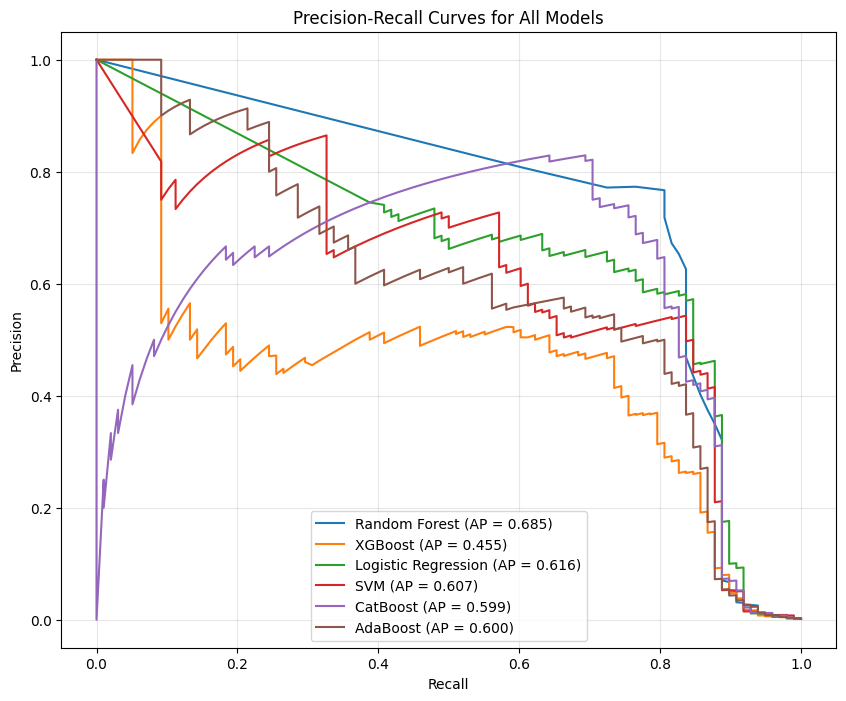

In [15]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    precision_score, recall_score, f1_score, roc_curve, 
    precision_recall_curve, auc, average_precision_score
)
import xgboost as xgb
from catboost import CatBoostClassifier
from collections import defaultdict
import time

# Ensure datasets are numpy arrays
X_train_balanced = np.array(X_train_balanced)
y_train_balanced = np.array(y_train_balanced)
X_test_with_re = np.array(X_test_with_re)
y_test = np.array(y_test)

# Define classification models to evaluate (removed Gradient Boosting, added CatBoost and AdaBoost)
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    'SVM': SVC(probability=True, random_state=42, class_weight='balanced'),
    'CatBoost': CatBoostClassifier(n_estimators=100, random_state=42, verbose=0),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42)
}

# 2. Function to plot confusion matrix
def plot_confusion_matrix(cm, title, normalize=False):
    plt.figure(figsize=(6, 5))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', 
                cmap='Blues', cbar=False)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks([0.5, 1.5], ['Normal', 'Fraud'])
    plt.yticks([0.5, 1.5], ['Normal', 'Fraud'])
    plt.tight_layout()

# Dictionaries to store results
results = defaultdict(dict)
y_probs = {}
training_times = {}
testing_times = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Training with timing
    start_time = time.time()
    model.fit(X_train_balanced, y_train_balanced)
    training_times[name] = time.time() - start_time
    
    # Prediction with timing
    start_time = time.time()
    y_pred = model.predict(X_test_with_re)
    y_prob = model.predict_proba(X_test_with_re)[:, 1]
    testing_times[name] = time.time() - start_time
    
    # Store results
    y_probs[name] = y_prob
    
    # Classification metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # ROC and PR curves
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall_curve, precision_curve)
    avg_precision = average_precision_score(y_test, y_prob)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Store all metrics
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
        'PR AUC': pr_auc,
        'Avg Precision': avg_precision,
        'Confusion Matrix': cm,
        'Training Time': training_times[name],
        'Testing Time': testing_times[name]
    }
    
    print(f"{name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    print(f"{name} - ROC AUC: {roc_auc:.4f}, PR AUC: {pr_auc:.4f}, Avg Precision: {avg_precision:.4f}")
    print(f"{name} - Training time: {training_times[name]:.2f}s, Testing time: {testing_times[name]:.2f}s")

# Plot confusion matrices for all models
plt.figure(figsize=(18, 12))
for i, (name, metrics) in enumerate(results.items()):
    plt.subplot(2, 3, i+1)
    cm = metrics['Confusion Matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks([0.5, 1.5], ['Normal', 'Fraud'])
    plt.yticks([0.5, 1.5], ['Normal', 'Fraud'])
plt.tight_layout()
plt.show()

# Plot ROC curves for all models
plt.figure(figsize=(10, 8))
for name, y_prob in y_probs.items():
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = results[name]['ROC AUC']
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# 7. Plot Precision-Recall curves for all models
plt.figure(figsize=(10, 8))
for name, y_prob in y_probs.items():
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_prob)
    avg_precision = results[name]['Avg Precision']
    plt.plot(recall_curve, precision_curve, label=f'{name} (AP = {avg_precision:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for All Models')
plt.legend(loc="best")
plt.grid(True, alpha=0.3)
plt.show()

In [16]:
def correct_with_threshold(y_true, y_pred, reconstruction_errors, threshold):
    """
    Corrects false predictions based on reconstruction error and threshold.
    
    Parameters:
    -----------
    y_true : array-like
        Ground truth labels (0 for normal, 1 for fraud)
    y_pred : array-like
        Model predictions (0 for normal, 1 for fraud)
    reconstruction_errors : array-like
        Reconstruction errors for each sample
    threshold : float
        Threshold value for reconstruction error
        
    Returns:
    --------
    dict
        Results including correction percentages and corrected predictions
    """
    import numpy as np
    from sklearn.metrics import confusion_matrix
    
    # Identify false predictions
    false_positives_mask = (y_true == 0) & (y_pred == 1)  # Normal predicted as fraud
    false_negatives_mask = (y_true == 1) & (y_pred == 0)  # Fraud predicted as normal
    
    # Get counts
    fp_count = np.sum(false_positives_mask)
    fn_count = np.sum(false_negatives_mask)
    
    # Get reconstruction errors for false predictions
    fp_errors = reconstruction_errors[false_positives_mask]
    fn_errors = reconstruction_errors[false_negatives_mask]
    
    # Apply correction rules:
    # 1. If normal transaction (falsely predicted as fraud) has RE < threshold, correct to normal
    # 2. If fraud transaction (falsely predicted as normal) has RE > threshold, correct to fraud
    fp_corrected = np.sum(fp_errors < threshold)
    fn_corrected = np.sum(fn_errors > threshold)
    
    # Calculate percentages
    fp_correction_pct = (fp_corrected / fp_count) * 100 if fp_count > 0 else 0
    fn_correction_pct = (fn_corrected / fn_count) * 100 if fn_count > 0 else 0
    
    # Create corrected predictions
    y_pred_corrected = y_pred.copy()
    
    # Correct false positives (normal transactions predicted as fraud)
    fp_indices = np.where(false_positives_mask)[0]
    fp_to_correct_mask = fp_errors < threshold
    if len(fp_indices) > 0 and len(fp_to_correct_mask) > 0:
        fp_to_correct = fp_indices[fp_to_correct_mask]
        y_pred_corrected[fp_to_correct] = 0  # Change prediction to normal
    
    # Correct false negatives (fraud transactions predicted as normal)
    fn_indices = np.where(false_negatives_mask)[0]
    fn_to_correct_mask = fn_errors > threshold
    if len(fn_indices) > 0 and len(fn_to_correct_mask) > 0:
        fn_to_correct = fn_indices[fn_to_correct_mask]
        y_pred_corrected[fn_to_correct] = 1  # Change prediction to fraud
    
    # Calculate new confusion matrix
    original_cm = confusion_matrix(y_true, y_pred)
    corrected_cm = confusion_matrix(y_true, y_pred_corrected)
    
    # Print results
    print(f"\nThreshold: {threshold:.4f}")
    print("\nCorrections:")
    print(f"  False Positives (Normal transactions incorrectly flagged as Fraud):")
    print(f"    {fp_corrected}/{fp_count} corrected ({fp_correction_pct:.2f}%)")
    print(f"  False Negatives (Fraud transactions incorrectly flagged as Normal):")
    print(f"    {fn_corrected}/{fn_count} corrected ({fn_correction_pct:.2f}%)")
    
    print("\nOriginal Confusion Matrix:")
    print(original_cm)
    print("\nCorrected Confusion Matrix:")
    print(corrected_cm)
    
    return {
        'y_pred_corrected': y_pred_corrected,
        'false_positives': {
            'total': fp_count,
            'corrected': int(fp_corrected),
            'percentage': fp_correction_pct
        },
        'false_negatives': {
            'total': fn_count,
            'corrected': int(fn_corrected),
            'percentage': fn_correction_pct
        },
        'original_cm': original_cm,
        'corrected_cm': corrected_cm
    }

threshold = 4.5
corrections = correct_with_threshold(y_test, y_pred, test_errors, threshold)


Threshold: 4.5000

Corrections:
  False Positives (Normal transactions incorrectly flagged as Fraud):
    3045/3149 corrected (96.70%)
  False Negatives (Fraud transactions incorrectly flagged as Normal):
    0/8 corrected (0.00%)

Original Confusion Matrix:
[[53715  3149]
 [    8    90]]

Corrected Confusion Matrix:
[[56760   104]
 [    8    90]]



Threshold: 0.0650

Corrections:
  False Positives (Normal transactions incorrectly flagged as Fraud):
    0/3149 corrected (0.00%)
  False Negatives (Fraud transactions incorrectly flagged as Normal):
    8/8 corrected (100.00%)

Original Confusion Matrix:
[[53715  3149]
 [    8    90]]

Corrected Confusion Matrix:
[[53715  3149]
 [    0    98]]

Threshold: 8.4709

Corrections:
  False Positives (Normal transactions incorrectly flagged as Fraud):
    3105/3149 corrected (98.60%)
  False Negatives (Fraud transactions incorrectly flagged as Normal):
    0/8 corrected (0.00%)

Original Confusion Matrix:
[[53715  3149]
 [    8    90]]

Corrected Confusion Matrix:
[[56820    44]
 [    8    90]]

Threshold: 16.8768

Corrections:
  False Positives (Normal transactions incorrectly flagged as Fraud):
    3126/3149 corrected (99.27%)
  False Negatives (Fraud transactions incorrectly flagged as Normal):
    0/8 corrected (0.00%)

Original Confusion Matrix:
[[53715  3149]
 [    8    90]]

Correct

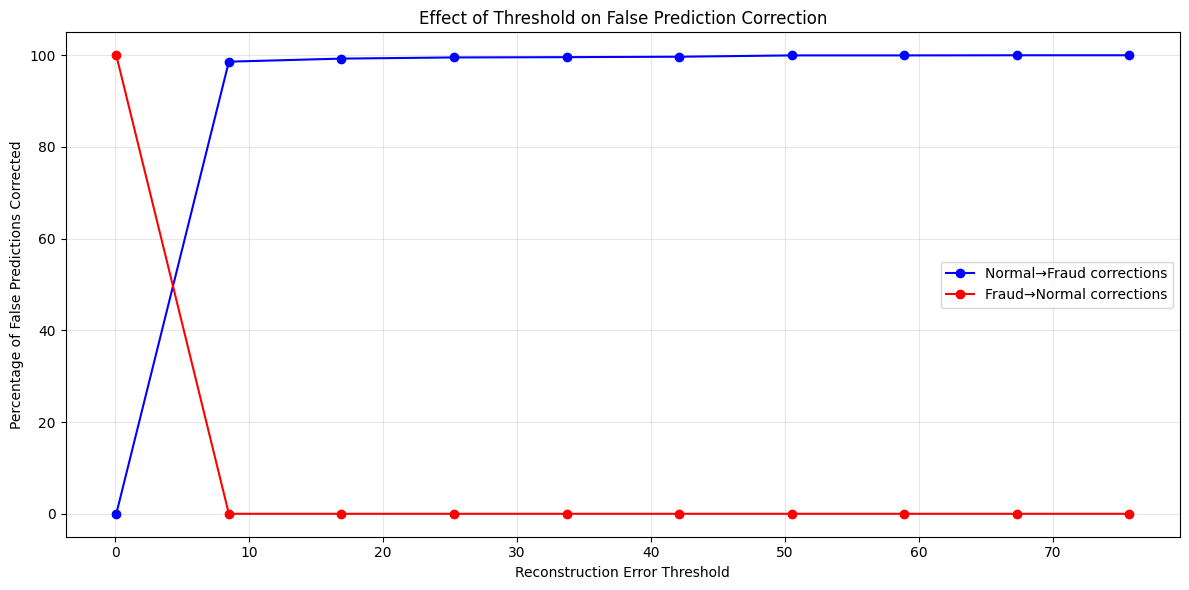

In [17]:
def analyze_threshold_range(y_true, y_pred, reconstruction_errors, thresholds):
    """
    Analyzes the effect of different thresholds on correcting false predictions.
    
    Parameters:
    -----------
    y_true : array-like
        Ground truth labels (0 for normal, 1 for fraud)
    y_pred : array-like
        Model predictions (0 for normal, 1 for fraud)
    reconstruction_errors : array-like
        Reconstruction errors for each sample
    thresholds : list or array
        List of threshold values to analyze
        
    Returns:
    --------
    dict
        Results for each threshold
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    results = {}
    fp_corrections = []
    fn_corrections = []
    
    for threshold in thresholds:
        result = correct_with_threshold(y_true, y_pred, reconstruction_errors, threshold)
        results[threshold] = result
        fp_corrections.append(result['false_positives']['percentage'])
        fn_corrections.append(result['false_negatives']['percentage'])
    
    # Visualize results
    plt.figure(figsize=(12, 6))
    plt.plot(thresholds, fp_corrections, 'b-', marker='o', label='Normal→Fraud corrections')
    plt.plot(thresholds, fn_corrections, 'r-', marker='o', label='Fraud→Normal corrections')
    plt.grid(True, alpha=0.3)
    plt.xlabel('Reconstruction Error Threshold')
    plt.ylabel('Percentage of False Predictions Corrected')
    plt.title('Effect of Threshold on False Prediction Correction')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return results

# Try a range of thresholds
min_error = np.min(test_errors)
max_error = np.max(test_errors)
thresholds = np.linspace(min_error, max_error, 10)  # 10 thresholds between min and max
results = analyze_threshold_range(y_test, y_pred, test_errors, thresholds)

In [18]:
# First, check the actual number of features in your data
print(f"X_train_balanced shape: {X_train_balanced.shape}")
print(f"X_test_with_re shape: {X_test_with_re.shape}")

# Adjust feature names to match the actual number of features
feature_dim = X_train_balanced.shape[1]  # Get actual feature count

if feature_dim == 30:  # If we have 30 features
    # Option 1: This is the most likely scenario - we're missing a feature
    original_features = [f'V{i}' for i in range(1, 29)] + ['Amount']  # Drop Time
    feature_names = original_features + ['Reconstruction_Error']
elif feature_dim == 31:  # If we have 31 features 
    # Keep your original code
    original_features = [f'V{i}' for i in range(1, 29)] + ['Time', 'Amount']
    feature_names = original_features + ['Reconstruction_Error']
else:
    # Just create generic feature names based on actual dimension
    feature_names = [f'Feature_{i}' for i in range(feature_dim)]
    
print(f"Number of feature names: {len(feature_names)}")

# Now proceed with creating importance_df
# Models that support feature_importances_
tree_based_models = ['Random Forest', 'XGBoost', 'CatBoost', 'AdaBoost']
feature_importance_dict = {}

# Collect feature importances from each model
for name in tree_based_models:
    if hasattr(models[name], 'feature_importances_'):
        importances = models[name].feature_importances_
        print(f"{name} importance shape: {importances.shape}")
        feature_importance_dict[name] = importances

# Create a DataFrame with feature importances
importance_df = pd.DataFrame(feature_importance_dict, index=feature_names)

X_train_balanced shape: (788, 30)
X_test_with_re shape: (56962, 30)
Number of feature names: 30
Random Forest importance shape: (30,)
XGBoost importance shape: (30,)
CatBoost importance shape: (30,)
AdaBoost importance shape: (30,)


<Figure size 1400x1000 with 0 Axes>

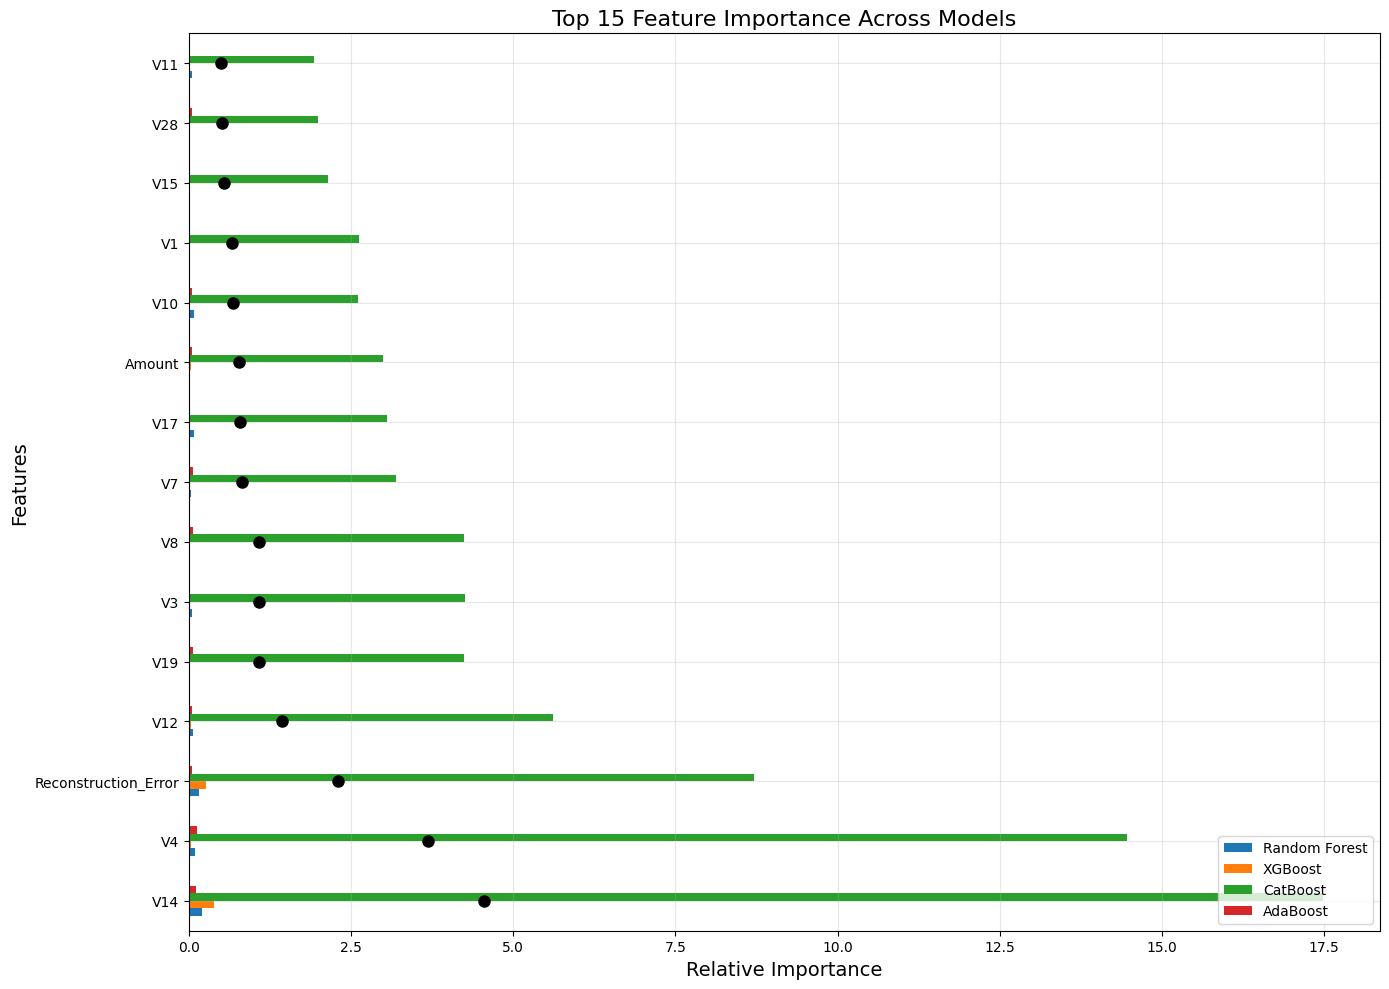


Random Forest: Reconstruction Error Importance = 0.1565 (Rank: 2 out of 30)

XGBoost: Reconstruction Error Importance = 0.2577 (Rank: 2 out of 30)

CatBoost: Reconstruction Error Importance = 8.7077 (Rank: 3 out of 30)

AdaBoost: Reconstruction Error Importance = 0.0450 (Rank: 8 out of 30)


In [19]:
# Feature importance analysis with corrected feature names
original_features = [f'V{i}' for i in range(1, 29)] + ['Amount']  # Time is dropped
feature_names = original_features + ['Reconstruction_Error']

# Enhanced unified feature importance plot
plt.figure(figsize=(14, 10))

# Models that support feature_importances_
tree_based_models = ['Random Forest', 'XGBoost', 'CatBoost', 'AdaBoost']
feature_importance_dict = {}

# Collect feature importances from each model
for name in tree_based_models:
    if hasattr(models[name], 'feature_importances_'):
        importances = models[name].feature_importances_
        feature_importance_dict[name] = importances

# Create a DataFrame with feature importances
importance_df = pd.DataFrame(feature_importance_dict, index=feature_names)

# Calculate average importance across models
importance_df['Average'] = importance_df.mean(axis=1)
importance_df = importance_df.sort_values('Average', ascending=False)

# Plot top 15 features
top_features = importance_df.head(15).index
top_importance_df = importance_df.loc[top_features]

# Plot all models side by side with a different color for each model
ax = top_importance_df.drop('Average', axis=1).plot(kind='barh', figsize=(14, 10))
plt.title('Top 15 Feature Importance Across Models', fontsize=16)
plt.xlabel('Relative Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.grid(alpha=0.3)
plt.legend(loc='lower right')

# Add average importance as black dots
for i, feature in enumerate(top_importance_df.index):
    plt.plot(top_importance_df.loc[feature, 'Average'], i, 'ko', ms=8, label='_nolegend_')

plt.tight_layout()
plt.show()

# 10. Check if reconstruction error is among top features
for name in tree_based_models:
    if hasattr(models[name], 'feature_importances_'):
        importances = models[name].feature_importances_
        re_importance = importances[-1]  # Assuming reconstruction error is the last feature
        re_rank = len(importances) - np.where(np.sort(importances) == re_importance)[0][0]
        print(f"\n{name}: Reconstruction Error Importance = {re_importance:.4f} (Rank: {re_rank} out of {len(importances)})")

### Remove data with high reconstruction errors, and train models using the new dataset. Check for undersampling and oversampling methods

In [20]:
# Calculate threshold based on normal transactions' reconstruction error
normal_re_mean = np.mean(train_errors[y_train == 0])
normal_re_std = np.std(train_errors[y_train == 0])
# Setting threshold as mean + 2 standard deviations
threshold = normal_re_mean + 4 * normal_re_std

print(f"Reconstruction error threshold: {threshold:.4f}")
print(f"Percentage of normal transactions below threshold: {(train_errors[y_train == 0] < threshold).mean() * 100:.2f}%")
print(f"Percentage of fraud transactions below threshold: {(train_errors[y_train == 1] < threshold).mean() * 100:.2f}%")

Reconstruction error threshold: 6.5380
Percentage of normal transactions below threshold: 99.81%
Percentage of fraud transactions below threshold: 39.59%


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


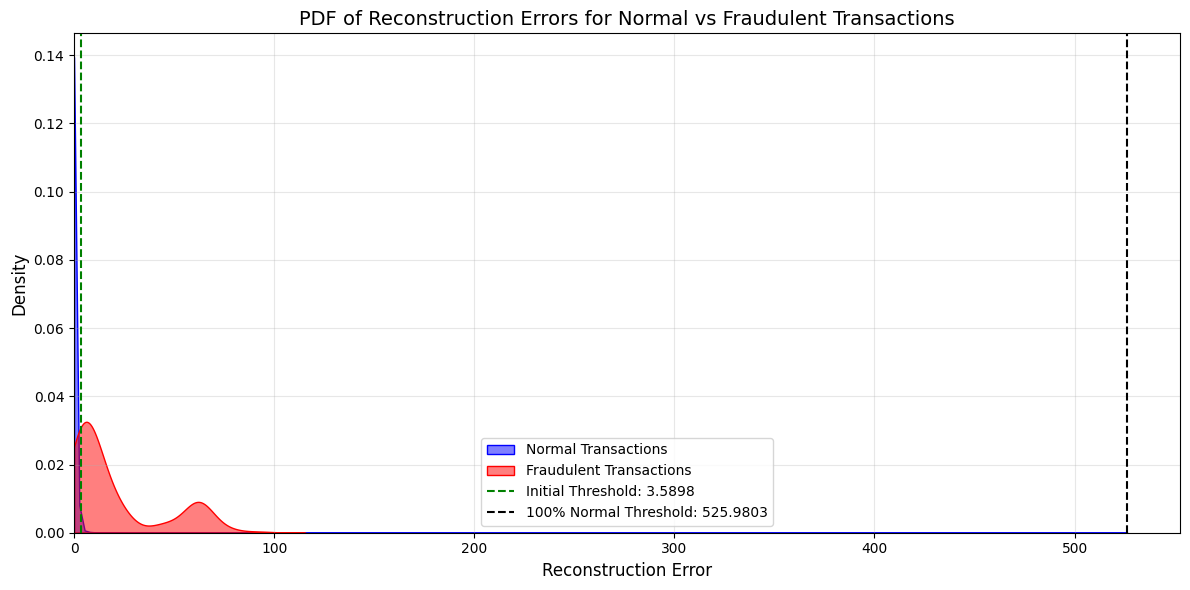

In [21]:
# Set up the figure
plt.figure(figsize=(12, 6))

# Get the reconstruction error arrays for each class
normal_errors = train_errors[y_train == 0]
fraud_errors = train_errors[y_train == 1]

# Plot PDFs using KDE with boundary correction
sns.kdeplot(normal_errors, fill=True, alpha=0.5, label='Normal Transactions', 
            color='blue', clip=(0, None))  # Clip at 0 to prevent negative values
sns.kdeplot(fraud_errors, fill=True, alpha=0.5, label='Fraudulent Transactions', 
            color='red', clip=(0, None))   # Clip at 0 to prevent negative values

# Add the two threshold lines
# 1. The initial threshold (mean + 2*std)
initial_threshold = normal_re_mean + 2 * normal_re_std
plt.axvline(x=initial_threshold, color='green', linestyle='--', 
            label=f'Initial Threshold: {initial_threshold:.4f}')

# 2. The 100% normal threshold
max_normal_threshold = np.max(normal_errors) + 1e-6
plt.axvline(x=max_normal_threshold, color='black', linestyle='--',
            label=f'100% Normal Threshold: {max_normal_threshold:.4f}')

# Set x-axis to start at 0
plt.xlim(left=0)

# Add labels and title
plt.xlabel('Reconstruction Error', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('PDF of Reconstruction Errors for Normal vs Fraudulent Transactions', fontsize=14)

# Add a legend
plt.legend(loc='best')

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Show plot
plt.tight_layout()
plt.show()

This means that almost 855 normal transactions (284807 * 0.003) will be flaged as fraud if we only use the reconstruction error for classification, and 35.5% of fraudulent transactions wont be detected. 

In [22]:
# Filter training data
train_mask = train_errors < threshold
X_train_filtered = X_train[train_mask]
y_train_filtered = y_train[train_mask]
train_errors_filtered = train_errors[train_mask]
X_train_filtered_with_re = np.column_stack([X_train_filtered, train_errors_filtered])

# Filter test data
test_mask = test_errors < threshold
X_test_filtered = X_test[test_mask]
y_test_filtered = y_test[test_mask]
test_errors_filtered = test_errors[test_mask]
X_test_filtered_with_re = np.column_stack([X_test_filtered, test_errors_filtered])

# Print summary of filtered datasets
print("\nFiltered datasets:")
print(f"Training: {X_train_filtered.shape[0]} samples, {sum(y_train_filtered == 1)} frauds ({sum(y_train_filtered == 1)/len(y_train_filtered)*100:.2f}%)")
print(f"Testing: {X_test_filtered.shape[0]} samples, {sum(y_test_filtered == 1)} frauds ({sum(y_test_filtered == 1)/len(y_test_filtered)*100:.2f}%)")


Filtered datasets:
Training: 227174 samples, 156 frauds (0.07%)
Testing: 56781 samples, 36 frauds (0.06%)


In [23]:
# import time
# import tqdm
# import datetime

# # Define sampling techniques
# sampling_techniques = {
#     'RandomUnderSampler': RandomUnderSampler(sampling_strategy=0.3, random_state=42),  # Undersampling to 3:1 ratio
#     'SMOTETomek': SMOTETomek(sampling_strategy=0.7, random_state=42)  # Hybrid approach to ~1.5:1 ratio
# }

# # Define models
# models = {
#     'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
#     'XGBoost': xgb.XGBClassifier(n_estimators=100, random_state=42),
#     'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
#     'CatBoost': CatBoostClassifier(n_estimators=100, random_state=42, verbose=0),
#     'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42)
# }

# # Dictionaries to store results
# all_results = {}
# sampling_times = {}

# # Function to format time
# def format_time(seconds):
#     return str(datetime.timedelta(seconds=round(seconds)))

# # Function to evaluate model
# def evaluate_model(model, X_train, y_train, X_test, y_test):
#     # Train model
#     start_time = time.time()
#     model.fit(X_train, y_train)
#     training_time = time.time() - start_time
    
#     # Predict
#     start_time = time.time()
#     y_pred = model.predict(X_test)
#     y_prob = model.predict_proba(X_test)[:, 1]
#     testing_time = time.time() - start_time
    
#     # Calculate metrics
#     accuracy = accuracy_score(y_test, y_pred)
#     precision = precision_score(y_test, y_pred)
#     recall = recall_score(y_test, y_pred)
#     f1 = f1_score(y_test, y_pred)
    
#     # ROC and PR curves
#     fpr, tpr, _ = roc_curve(y_test, y_prob)
#     roc_auc = auc(fpr, tpr)
    
#     precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_prob)
#     pr_auc = auc(recall_curve, precision_curve)
#     avg_precision = average_precision_score(y_test, y_prob)
    
#     # Confusion matrix
#     cm = confusion_matrix(y_test, y_pred)
    
#     return {
#         'Accuracy': accuracy,
#         'Precision': precision,
#         'Recall': recall,
#         'F1 Score': f1,
#         'ROC AUC': roc_auc,
#         'PR AUC': pr_auc,
#         'Avg Precision': avg_precision,
#         'Confusion Matrix': cm,
#         'Training Time': training_time,
#         'Testing Time': testing_time,
#         'y_prob': y_prob
#     }
    
# # Evaluate each sampling technique with each model
# total_experiments = len(sampling_techniques) * len(models)
# experiment_count = 0

# print("\nStarting experiments...")
# experiment_start_time = time.time()

# for sampling_name, sampler in sampling_techniques.items():
#     all_results[sampling_name] = {}
    
#     print(f"\n{sampling_name} sampling technique:")
#     sampling_start = time.time()
    
#     # Apply sampling technique if not Original
#     if sampler is not None:
#         print(f"  Generating samples... ", end="")
#         sample_time_start = time.time()
#         X_train_sampled, y_train_sampled = sampler.fit_resample(X_train_filtered_with_re, y_train_filtered)
#         sample_time = time.time() - sample_time_start
#         sampling_times[sampling_name] = sample_time
        
#         # Calculate and display class distribution after sampling
#         normal_after = sum(y_train_sampled == 0)
#         fraud_after = sum(y_train_sampled == 1)
#         ratio_after = normal_after / fraud_after
        
#         print(f"Done in {format_time(sample_time)}")
#         print(f"  Class distribution after sampling: {normal_after} normal, {fraud_after} fraud")
#         print(f"  Class ratio (normal:fraud): {ratio_after:.2f}:1")
#     else:
#         X_train_sampled, y_train_sampled = X_train_filtered_with_re, y_train_filtered
#         sampling_times[sampling_name] = 0
    
#     print(f"  Train data shape: {X_train_sampled.shape}, Classes: {np.bincount(y_train_sampled)}")
    
#     # Progress bar for models within this sampling technique
#     model_count = 0
    
#     # Evaluate each model using the UNCHANGED test set
#     for model_name, model in models.items():
#         experiment_count += 1
#         model_count += 1
        
#         model_prefix = f"  [Model {model_count}/{len(models)}] {model_name}:"
#         print(f"{model_prefix} Training... ", end="")
        
#         # Train and evaluate - using the original test set
#         start_time = time.time()
#         results = evaluate_model(model, X_train_sampled, y_train_sampled, X_test_filtered_with_re, y_test_filtered)
#         all_results[sampling_name][model_name] = results
        
#         model_time = time.time() - start_time
        
#         # Print metrics
#         print(f"Done in {format_time(model_time)}")
#         print(f"    Accuracy: {results['Accuracy']:.4f}, Precision: {results['Precision']:.4f}, ")
#         print(f"    Recall: {results['Recall']:.4f}, F1: {results['F1 Score']:.4f}")
#         print(f"    ROC AUC: {results['ROC AUC']:.4f}, PR AUC: {results['PR AUC']:.4f}")
        
#         # Show overall progress
#         overall_progress = experiment_count / total_experiments * 100
#         elapsed = time.time() - experiment_start_time
#         est_total = elapsed * total_experiments / experiment_count
#         remaining = est_total - elapsed
        
#         print(f"\nOverall progress: {experiment_count}/{total_experiments} experiments ({overall_progress:.1f}%)")
#         print(f"Elapsed time: {format_time(elapsed)} | Estimated remaining: {format_time(remaining)}")
        
#     sampling_end = time.time() - sampling_start
#     print(f"\nCompleted {sampling_name} sampling in {format_time(sampling_end)}")

# total_time = time.time() - experiment_start_time
# print(f"\nAll experiments completed in {format_time(total_time)}!")

# # Create a timing summary table
# timing_df = pd.DataFrame(index=sampling_techniques.keys(), columns=['Sampling Time (s)'] + 
#                          [f"{model} Training (s)" for model in models.keys()])

# for sampling_name in sampling_techniques.keys():
#     timing_df.loc[sampling_name, 'Sampling Time (s)'] = sampling_times.get(sampling_name, 0)
#     for model_name in models.keys():
#         timing_df.loc[sampling_name, f"{model_name} Training (s)"] = all_results[sampling_name][model_name]['Training Time']

# # Display timing summary
# print("\nTiming Summary (seconds):")
# print(timing_df)

# # Create comparison tables
# metrics = ['F1 Score', 'Precision', 'Recall', 'ROC AUC', 'PR AUC']
# comparison_results = {}

# for metric in metrics:
#     comparison_df = pd.DataFrame(index=sampling_techniques.keys(), columns=models.keys())
    
#     for sampling_name in sampling_techniques.keys():
#         for model_name in models.keys():
#             comparison_df.loc[sampling_name, model_name] = all_results[sampling_name][model_name][metric]
    
#     comparison_results[metric] = comparison_df

# # Function to plot heatmap
# def plot_metric_heatmap(df, metric):
#     plt.figure(figsize=(12, 8))
#     sns.heatmap(df, annot=True, cmap='YlGnBu', fmt='.4f', cbar=True)
#     plt.title(f'Comparison of {metric} across Sampling Techniques and Models', fontsize=14)
#     plt.tight_layout()
#     plt.show()

# # Plot heatmaps
# for metric, df in comparison_results.items():
#     df_numeric = df.astype(float)            
#     plot_metric_heatmap(df_numeric, metric)

# # Plot timing heatmap
# plt.figure(figsize=(15, 8))
# # Calculate total time (sampling + training)
# total_time_df = timing_df.copy()
# total_time_df['Total Time (s)'] = timing_df['Sampling Time (s)']
# for model_name in models.keys():
#     total_time_df['Total Time (s)'] += timing_df[f"{model_name} Training (s)"]

# # Convert to log scale for better visualization of large time differences
# total_time_df = total_time_df.astype(float)
# log_time_df = np.log10(total_time_df + 1)  # +1 to avoid log(0)
# sns.heatmap(log_time_df, annot=total_time_df, fmt='.1f', cmap='Reds', cbar=True)
# plt.title('Time Comparison (seconds) - Log Scale Coloring', fontsize=14)
# plt.tight_layout()
# plt.show()

# # Plot ROC curves for best performing combinations
# plt.figure(figsize=(12, 10))

# # Select top sampling-model combinations based on ROC AUC
# top_combinations = []
# for sampling_name in sampling_techniques.keys():
#     for model_name in models.keys():
#         top_combinations.append((
#             sampling_name, 
#             model_name, 
#             all_results[sampling_name][model_name]['ROC AUC']
#         ))

# top_combinations = sorted(top_combinations, key=lambda x: x[2], reverse=True)[:5]

# # Plot ROC curves
# for sampling_name, model_name, roc_auc in top_combinations:
#     y_prob = all_results[sampling_name][model_name]['y_prob']
#     fpr, tpr, _ = roc_curve(y_test_filtered, y_prob)
#     plt.plot(fpr, tpr, label=f'{sampling_name} + {model_name} (AUC = {roc_auc:.4f})')

# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curves for Top 5 Model Combinations')
# plt.legend(loc="lower right")
# plt.grid(True, alpha=0.3)
# plt.show()

In [24]:
# # Find the best model combination
# best_sampling, best_model, *_ = top_combinations[0]

# # Get all combinations
# all_combinations = []
# for sampling_name in sampling_techniques.keys():
#     for model_name in models.keys():
#         all_combinations.append((sampling_name, model_name))

# # Plot 2 confusion matrices per figure
# plots_per_figure = 2
# num_figures = (len(all_combinations) + plots_per_figure - 1) // plots_per_figure  # Ceiling division

# for fig_num in range(num_figures):
#     # Create a new figure for every 2 plots
#     plt.figure(figsize=(12, 5))
    
#     # Determine which combinations to plot in this figure
#     start_idx = fig_num * plots_per_figure
#     end_idx = min(start_idx + plots_per_figure, len(all_combinations))
    
#     # Loop through combinations for this figure
#     for i, (sampling_name, model_name) in enumerate(all_combinations[start_idx:end_idx]):
#         # Get confusion matrix
#         cm = all_results[sampling_name][model_name]['Confusion Matrix']
        
#         # Calculate unidentified fraud percentage
#         total_fraud = cm[1][0] + cm[1][1]  # FN + TP
#         unidentified_fraud = cm[1][0]      # FN
#         fraud_missed_pct = (unidentified_fraud / total_fraud * 100) if total_fraud > 0 else 0
        
#         # Highlight the best model
#         title = f'{sampling_name} + {model_name}'
#         if sampling_name == best_sampling and model_name == best_model:
#             title += " (BEST)"
        
#         # Create subplot
#         ax = plt.subplot(1, plots_per_figure, i + 1)
#         sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
#         ax.set_title(f'{title}\nUnidentified Fraud: {fraud_missed_pct:.2f}%', fontsize=12)
#         ax.set_ylabel('True Label', fontsize=10)
#         ax.set_xlabel('Predicted Label', fontsize=10)
#         ax.set_xticks([0.5, 1.5])
#         ax.set_xticklabels(['Normal', 'Fraud'])
#         ax.set_yticks([0.5, 1.5])
#         ax.set_yticklabels(['Normal', 'Fraud'])
    
#     plt.tight_layout()
#     plt.show()
    
#     # Optional: Add a small pause between figures for better viewing
#     if fig_num < num_figures - 1:
#         print("\n--- Next Figure ---\n")

### Run XGBoost, CatBoost, Random Forest...etc First and then use AutoEncoder for filtering

In [25]:
# Stratified split to maintain fraud distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42)

scaler = StandardScaler()

# fit on only one column
scaler.fit(X_train[['Amount']])

# transform column in each split
for df in [X_train, X_test]:
    df[['Amount']] = scaler.transform(df[['Amount']])


Training Random Forest...
Random Forest - Accuracy: 0.9996, Precision: 0.9740, Recall: 0.7653, F1: 0.8571
Random Forest - ROC AUC: 0.9526, PR AUC: 0.8677, Avg Precision: 0.8614
Random Forest - Training time: 223.10s, Testing time: 0.70s

Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [14:41:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [14:41:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [14:41:07] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.


XGBoost - Accuracy: 0.9996, Precision: 0.9750, Recall: 0.7959, F1: 0.8764
XGBoost - ROC AUC: 0.9843, PR AUC: 0.8840, Avg Precision: 0.8841
XGBoost - Training time: 1.35s, Testing time: 0.08s

Training Logistic Regression...
Logistic Regression - Accuracy: 0.9759, Precision: 0.0618, Recall: 0.9184, F1: 0.1158
Logistic Regression - ROC AUC: 0.9804, PR AUC: 0.7596, Avg Precision: 0.7271
Logistic Regression - Training time: 1.69s, Testing time: 0.02s

Training CatBoost...
CatBoost - Accuracy: 0.9996, Precision: 0.9747, Recall: 0.7857, F1: 0.8701
CatBoost - ROC AUC: 0.9846, PR AUC: 0.8780, Avg Precision: 0.8781
CatBoost - Training time: 1.90s, Testing time: 0.07s


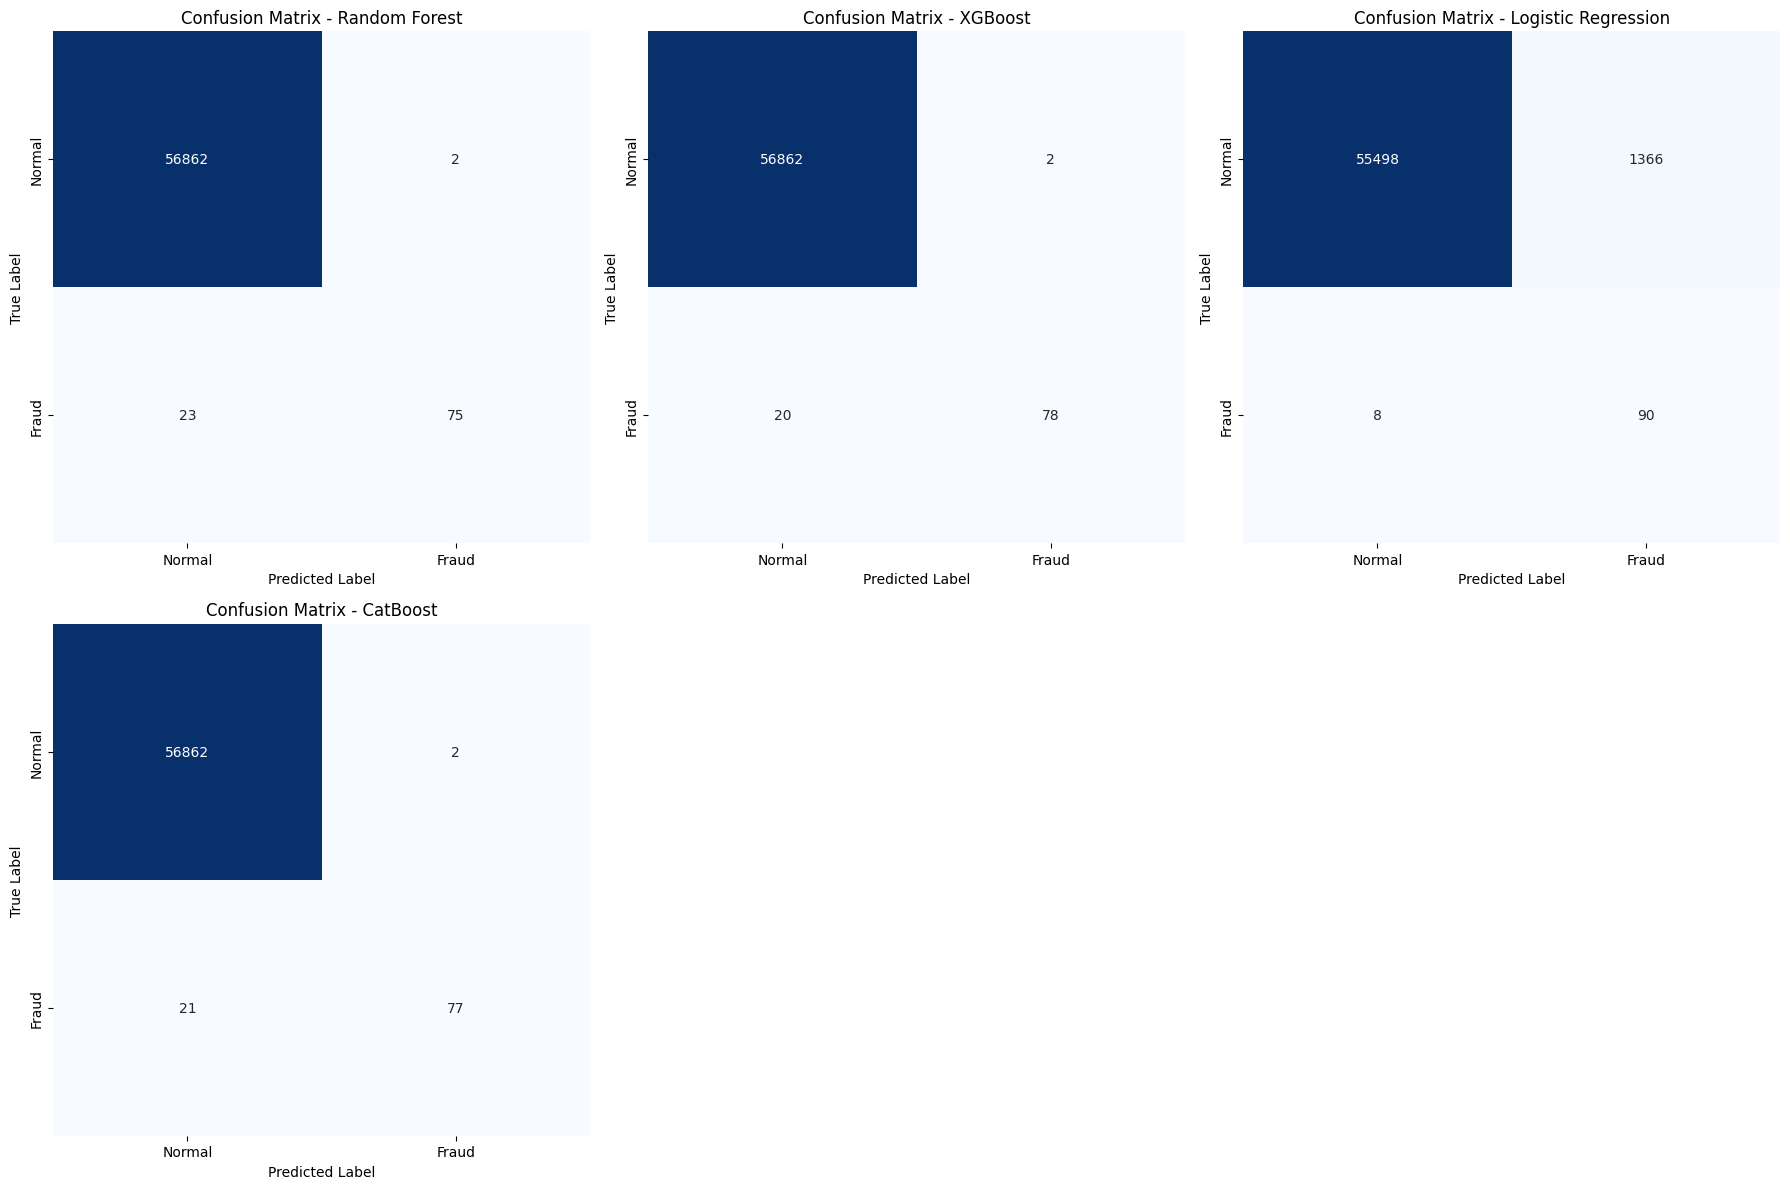

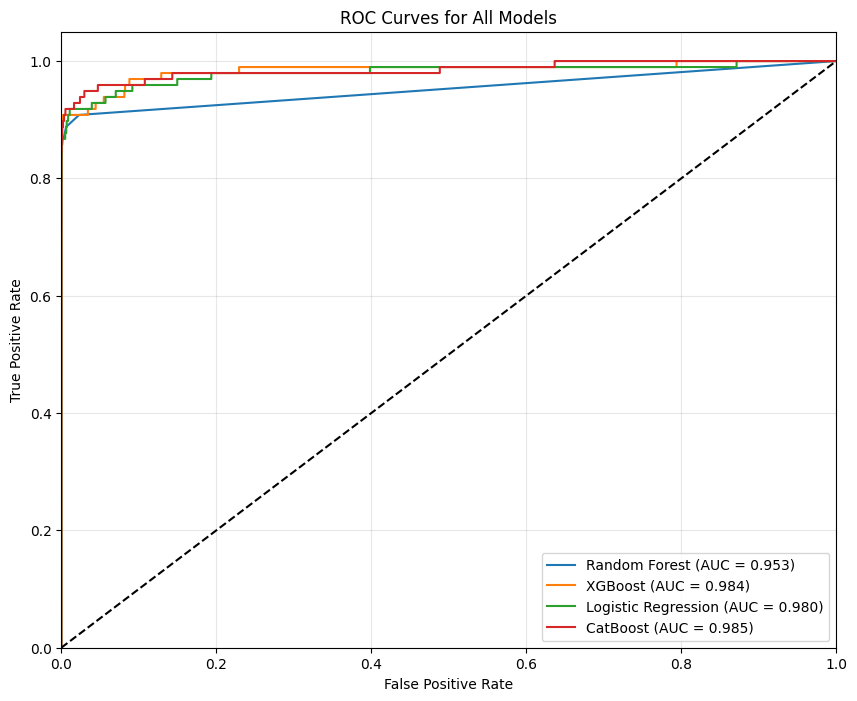

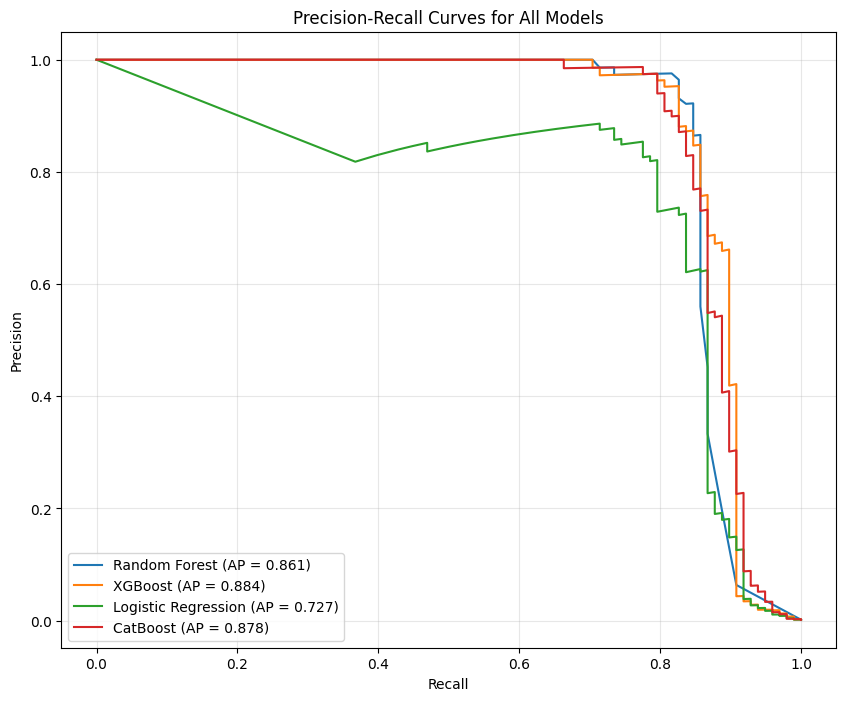

In [26]:
# Ensure datasets are numpy arrays
X_train_array = np.array(X_train)
y_train_array = np.array(y_train)
X_test_array = np.array(X_test)
y_test_array = np.array(y_test)

# Define classification models to evaluate (removed Gradient Boosting, added CatBoost and AdaBoost)
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, tree_method='gpu_hist', random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    'CatBoost': CatBoostClassifier(n_estimators=100, task_type='GPU', random_state=42, verbose=0)
}

# 2. Function to plot confusion matrix
def plot_confusion_matrix(cm, title, normalize=False):
    plt.figure(figsize=(6, 5))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', 
                cmap='Blues', cbar=False)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks([0.5, 1.5], ['Normal', 'Fraud'])
    plt.yticks([0.5, 1.5], ['Normal', 'Fraud'])
    plt.tight_layout()

# Dictionaries to store results
results = defaultdict(dict)
y_probs = {}
training_times = {}
testing_times = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Training with timing
    start_time = time.time()
    model.fit(X_train_array, y_train_array)
    training_times[name] = time.time() - start_time
    
    # Prediction with timing
    start_time = time.time()
    y_pred = model.predict(X_test_array)
    y_prob = model.predict_proba(X_test_array)[:, 1]
    testing_times[name] = time.time() - start_time
    
    # Store results
    y_probs[name] = y_prob
    
    # Classification metrics
    accuracy = accuracy_score(y_test_array, y_pred)
    precision = precision_score(y_test_array, y_pred)
    recall = recall_score(y_test_array, y_pred)
    f1 = f1_score(y_test_array, y_pred)
    
    # ROC and PR curves
    fpr, tpr, _ = roc_curve(y_test_array, y_prob)
    roc_auc = auc(fpr, tpr)
    
    precision_curve, recall_curve, _ = precision_recall_curve(y_test_array, y_prob)
    pr_auc = auc(recall_curve, precision_curve)
    avg_precision = average_precision_score(y_test_array, y_prob)
    
    # Confusion matrix
    cm = confusion_matrix(y_test_array, y_pred)
    
    # Store all metrics
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
        'PR AUC': pr_auc,
        'Avg Precision': avg_precision,
        'Confusion Matrix': cm,
        'Training Time': training_times[name],
        'Testing Time': testing_times[name]
    }
    
    print(f"{name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    print(f"{name} - ROC AUC: {roc_auc:.4f}, PR AUC: {pr_auc:.4f}, Avg Precision: {avg_precision:.4f}")
    print(f"{name} - Training time: {training_times[name]:.2f}s, Testing time: {testing_times[name]:.2f}s")

# Plot confusion matrices for all models
plt.figure(figsize=(18, 12))
for i, (name, metrics) in enumerate(results.items()):
    plt.subplot(2, 3, i+1)
    cm = metrics['Confusion Matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks([0.5, 1.5], ['Normal', 'Fraud'])
    plt.yticks([0.5, 1.5], ['Normal', 'Fraud'])
plt.tight_layout()
plt.show()

# Plot ROC curves for all models
plt.figure(figsize=(10, 8))
for name, y_prob in y_probs.items():
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = results[name]['ROC AUC']
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# 7. Plot Precision-Recall curves for all models
plt.figure(figsize=(10, 8))
for name, y_prob in y_probs.items():
    precision_curve, recall_curve, _ = precision_recall_curve(y_test_array, y_prob)
    avg_precision = results[name]['Avg Precision']
    plt.plot(recall_curve, precision_curve, label=f'{name} (AP = {avg_precision:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for All Models')
plt.legend(loc="best")
plt.grid(True, alpha=0.3)
plt.show()

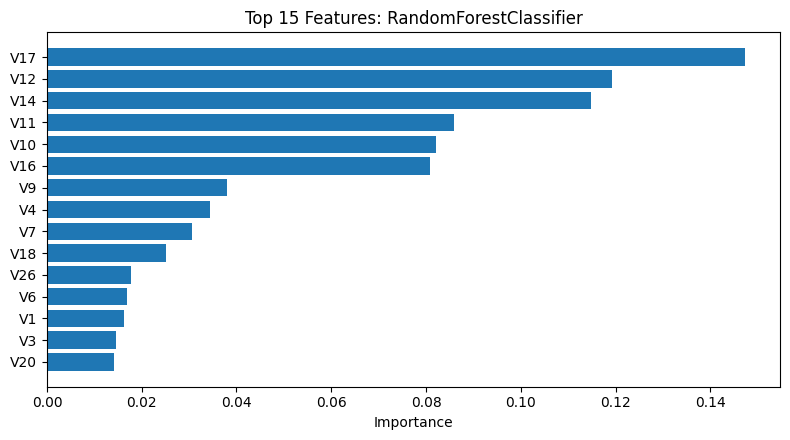

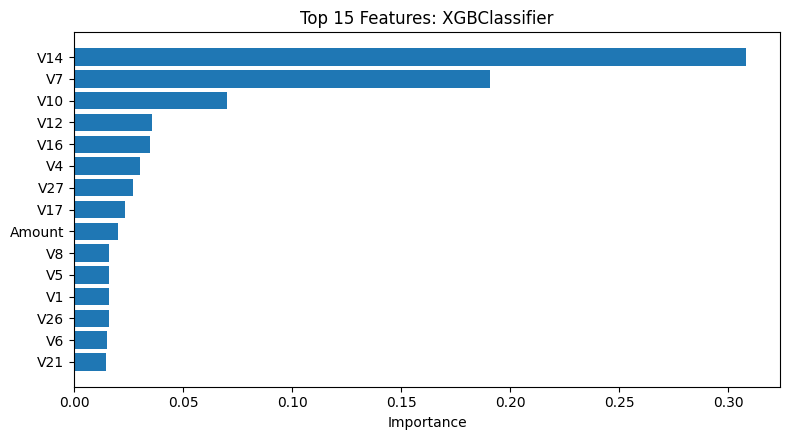

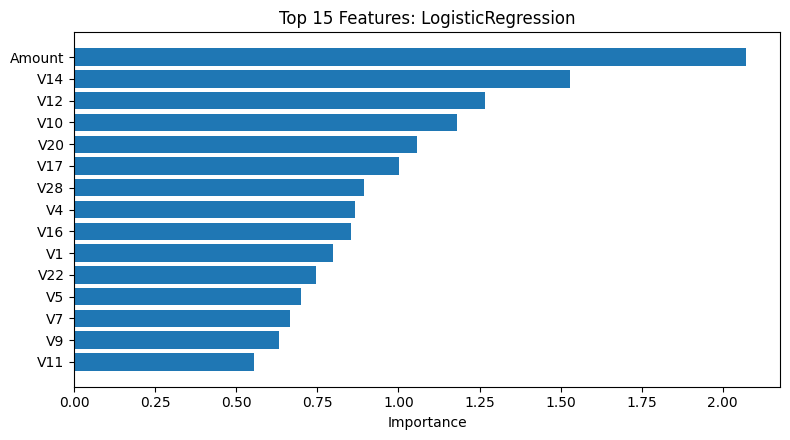

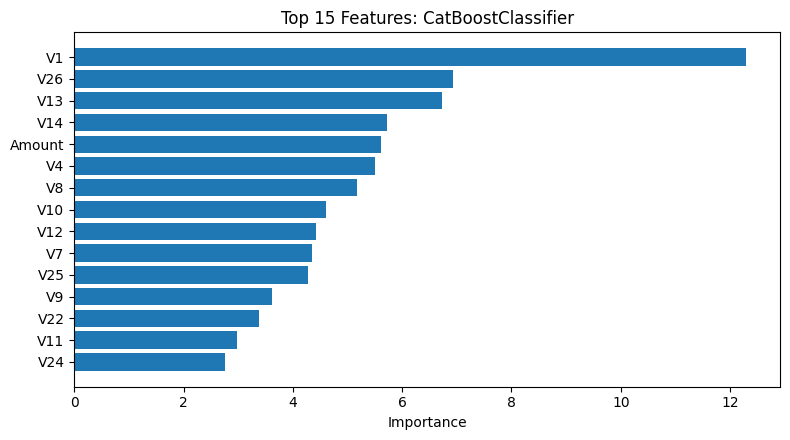

In [27]:
def plot_feature_importance(model, feature_names, top_n=20, ax=None):
    """
    Plots the top_n feature importances (or absolute coefficients) for a given model.
    """
    # Try feature_importances_, otherwise coef_
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
    elif hasattr(model, "coef_"):
        # For multiclass/regression coef_, take mean abs across classes
        coefs = model.coef_
        if coefs.ndim > 1:
            importances = np.mean(np.abs(coefs), axis=0)
        else:
            importances = np.abs(coefs)
    else:
        raise ValueError(f"Model {model.__class__.__name__} has no feature_importances_ or coef_.")

    # Get top features
    indices = np.argsort(importances)[::-1][:top_n]
    names = [feature_names[i] for i in indices]
    vals  = importances[indices]

    # Plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, top_n * 0.3))
    ax.barh(range(len(vals))[::-1], vals, align='center')
    ax.set_yticks(range(len(vals))[::-1])
    ax.set_yticklabels(names)
    ax.set_xlabel("Importance")
    ax.set_title(f"Top {top_n} Features: {model.__class__.__name__}")
    plt.tight_layout()
    return ax

# Example usage: loop through your models
feature_names = list(X.columns)  # or however you store your feature labels

for name, model in models.items():
    try:
        ax = plot_feature_importance(model, feature_names, top_n=15)
        plt.show()
    except ValueError as e:
        print(e)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

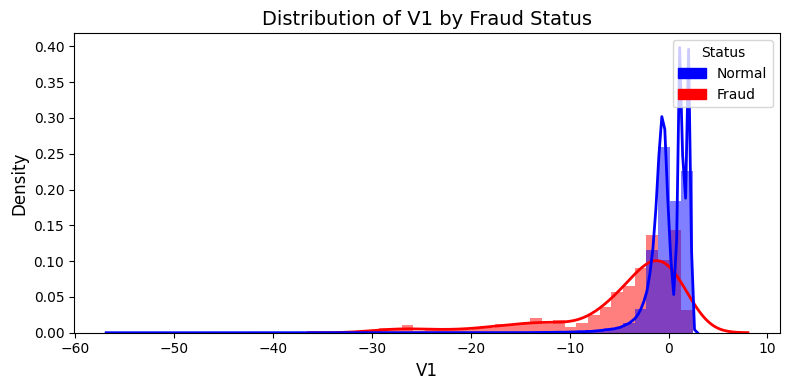

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

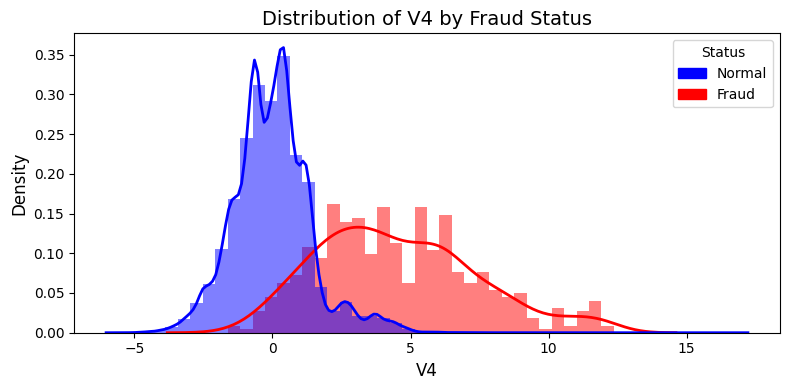

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

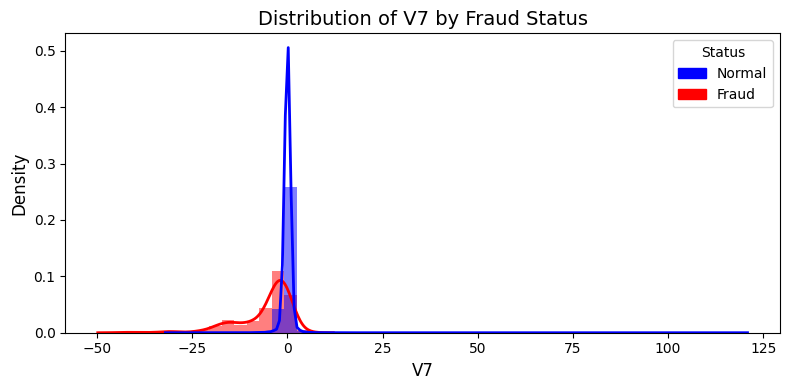

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

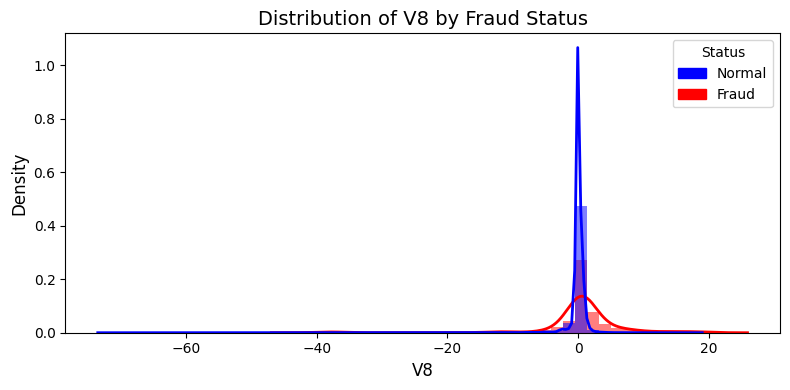

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

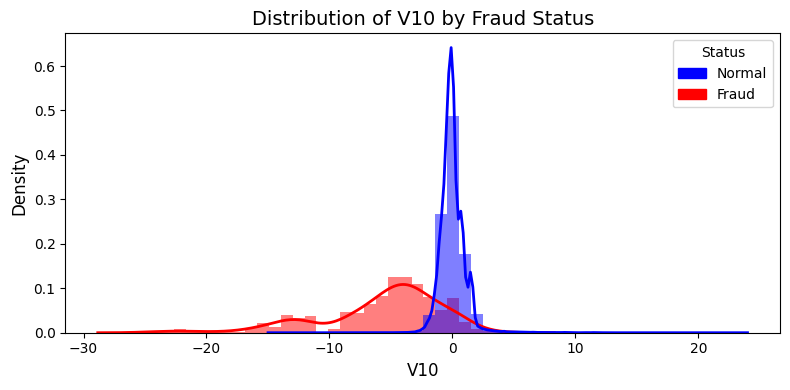

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

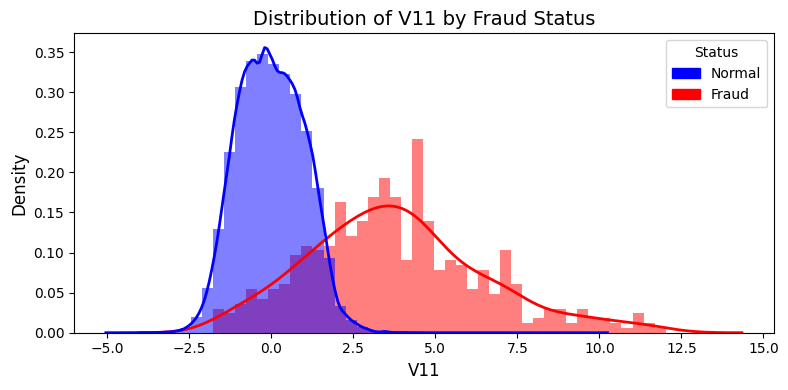

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

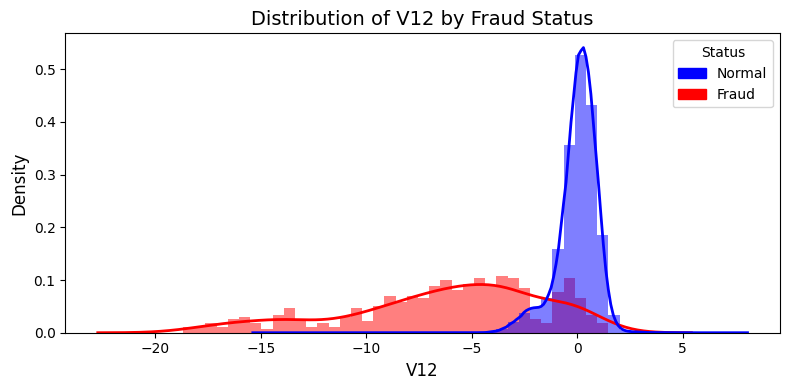

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

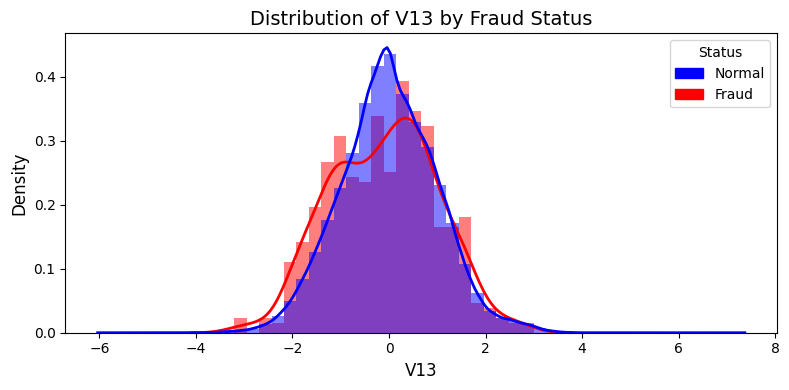

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

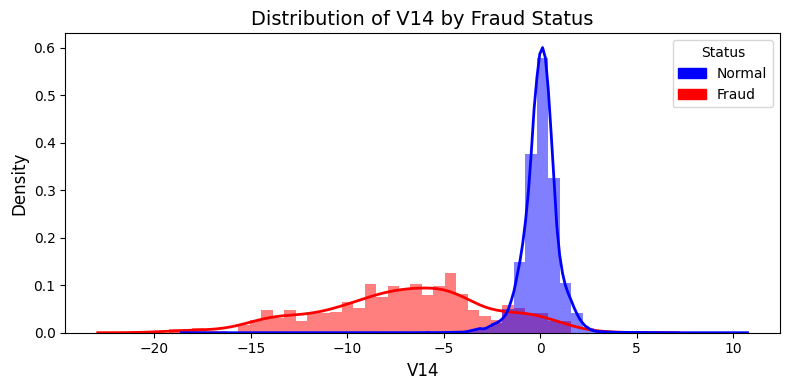

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

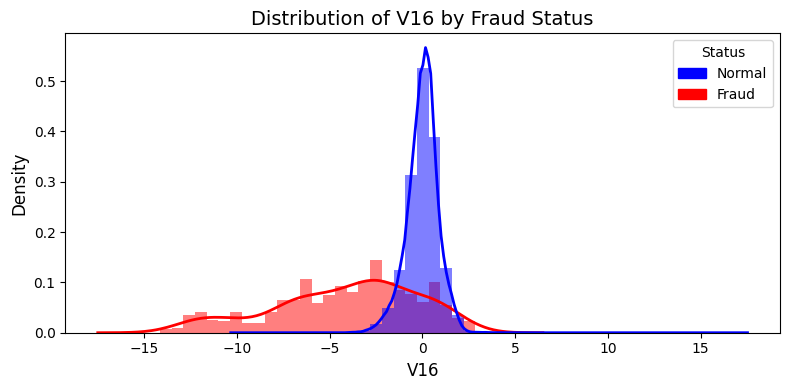

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

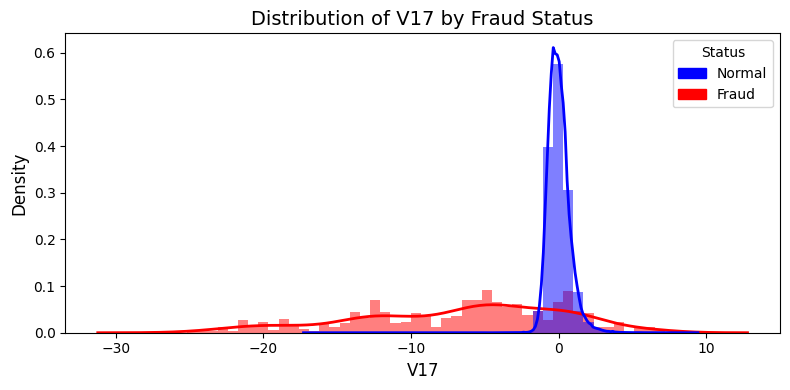

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

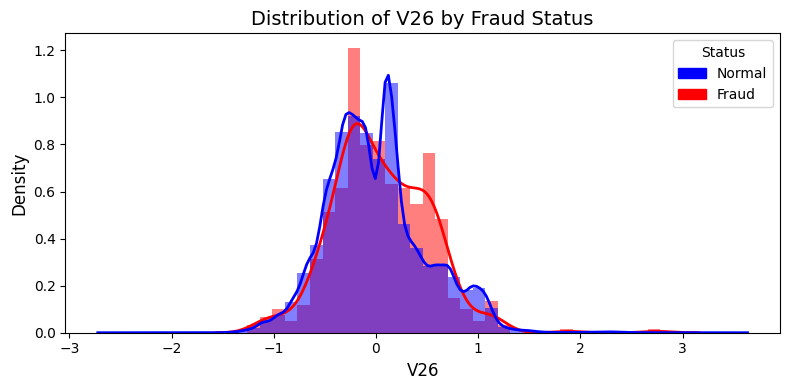

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Prepare DataFrame
df = X.copy()
df['Fraud'] = y.map({0: 'Normal', 1: 'Fraud'})  # map to string labels

cols = ['V1','V4','V7','V8','V10','V11', 'V12', 'V13', 'V14', 'V16', 'V17', 'V26']
palette = {'Normal': 'blue', 'Fraud': 'red'}

# Pre-define legend handles
legend_handles = [
    Patch(color=palette['Normal'], label='Normal'),
    Patch(color=palette['Fraud'], label='Fraud')
]

for col in cols:
    plt.figure(figsize=(8, 4))
    
    # Plot histograms & KDEs without seaborn legend
    sns.histplot(
        data=df, x=col, hue='Fraud',
        bins=50, stat='density', common_norm=False,
        alpha=0.5, palette=palette, edgecolor=None,
        legend=False
    )
    sns.kdeplot(
        data=df, x=col, hue='Fraud',
        common_norm=False, palette=palette,
        linewidth=2, legend=False
    )
    
    # Titles & axes
    plt.title(f'Distribution of {col} by Fraud Status', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Density', fontsize=12)
    
    # Add our custom legend
    plt.legend(handles=legend_handles, title='Status', loc='upper right')
    
    plt.tight_layout()
    plt.show()

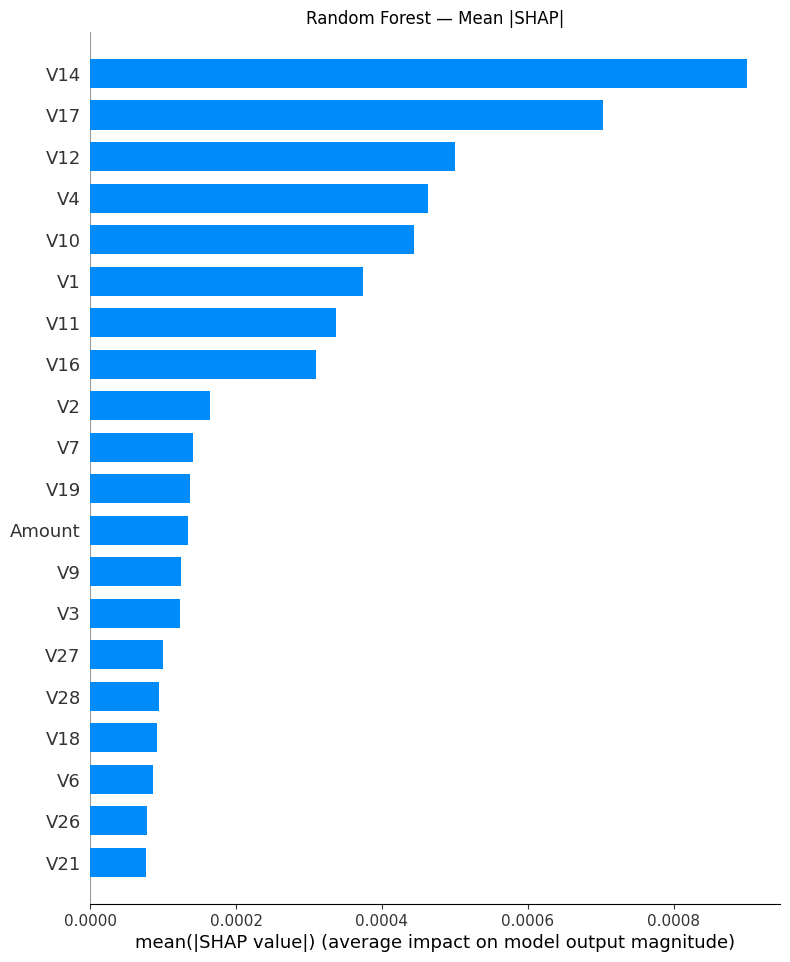

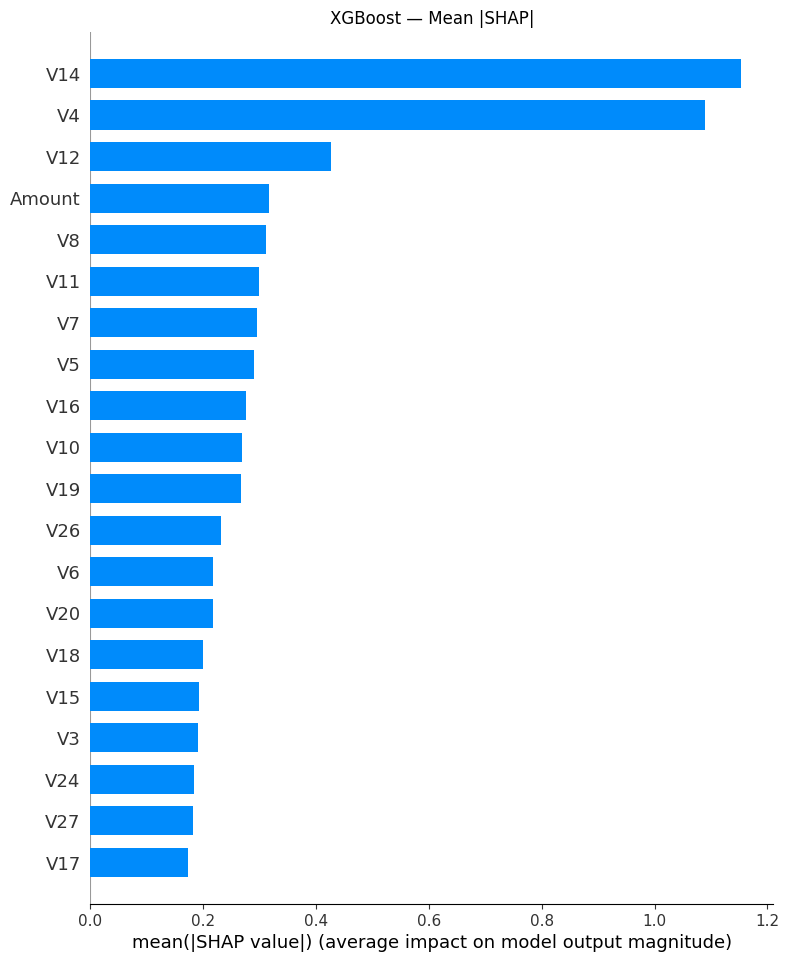

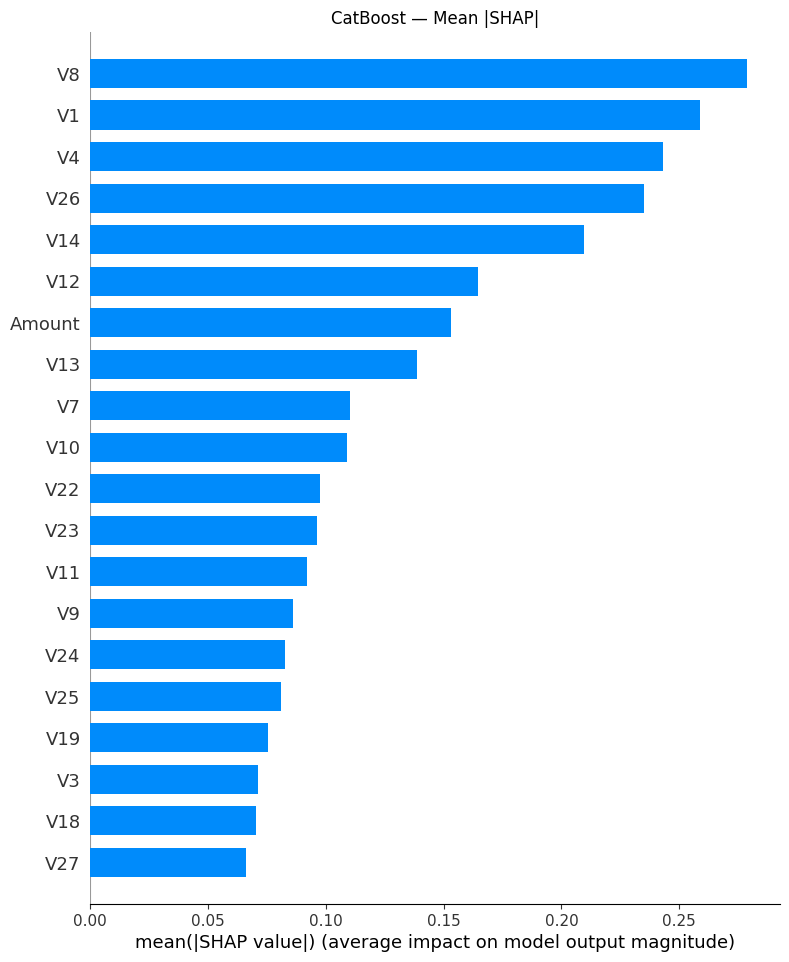

In [29]:
import shap

# 1) Wrap your arrays in DataFrames so SHAP can label features
X_train_df = pd.DataFrame(X_train_array, columns=feature_names)
X_test_df  = pd.DataFrame(X_test_array,  columns=feature_names)

# 2) Create a TreeExplainer & compute SHAP values for each model
shap_values = {}

# Random Forest
rf_explainer = shap.TreeExplainer(models['Random Forest'])
shap_values['Random Forest'] = rf_explainer.shap_values(X_test_df)  # list of arrays for each class

# XGBoost
xgb_explainer = shap.TreeExplainer(models['XGBoost'])
shap_values['XGBoost'] = xgb_explainer.shap_values(X_test_df)

# CatBoost
cb_explainer = shap.TreeExplainer(models['CatBoost'])
shap_values['CatBoost'] = cb_explainer.shap_values(X_test_df)

# 3) (Optional) Plot a global summary for each
for name, vals in shap_values.items():
    # For binary classifiers shap_values[name] is a list: [neg_class, pos_class]
    # We usually focus on the positive-class contributions:
    pos_shap = vals[1] if isinstance(vals, list) else vals
    shap.summary_plot(pos_shap, X_test_df, feature_names=feature_names, 
                      plot_type="bar", show=False)
    plt.title(f"{name} — Mean |SHAP|")
    plt.show()

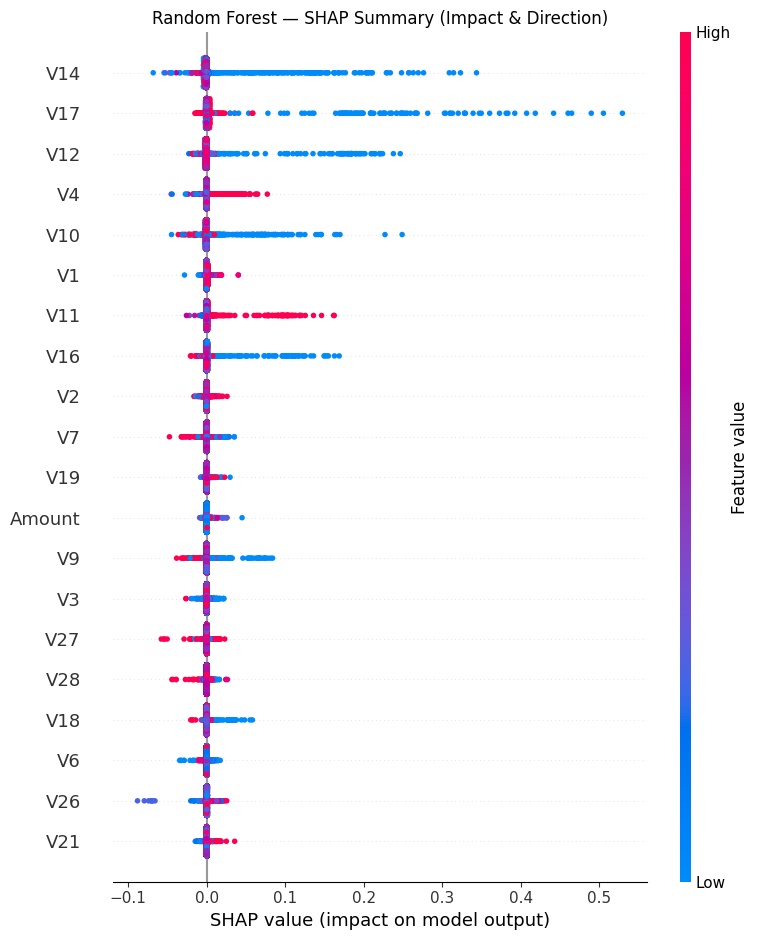

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.


<Figure size 1200x800 with 0 Axes>

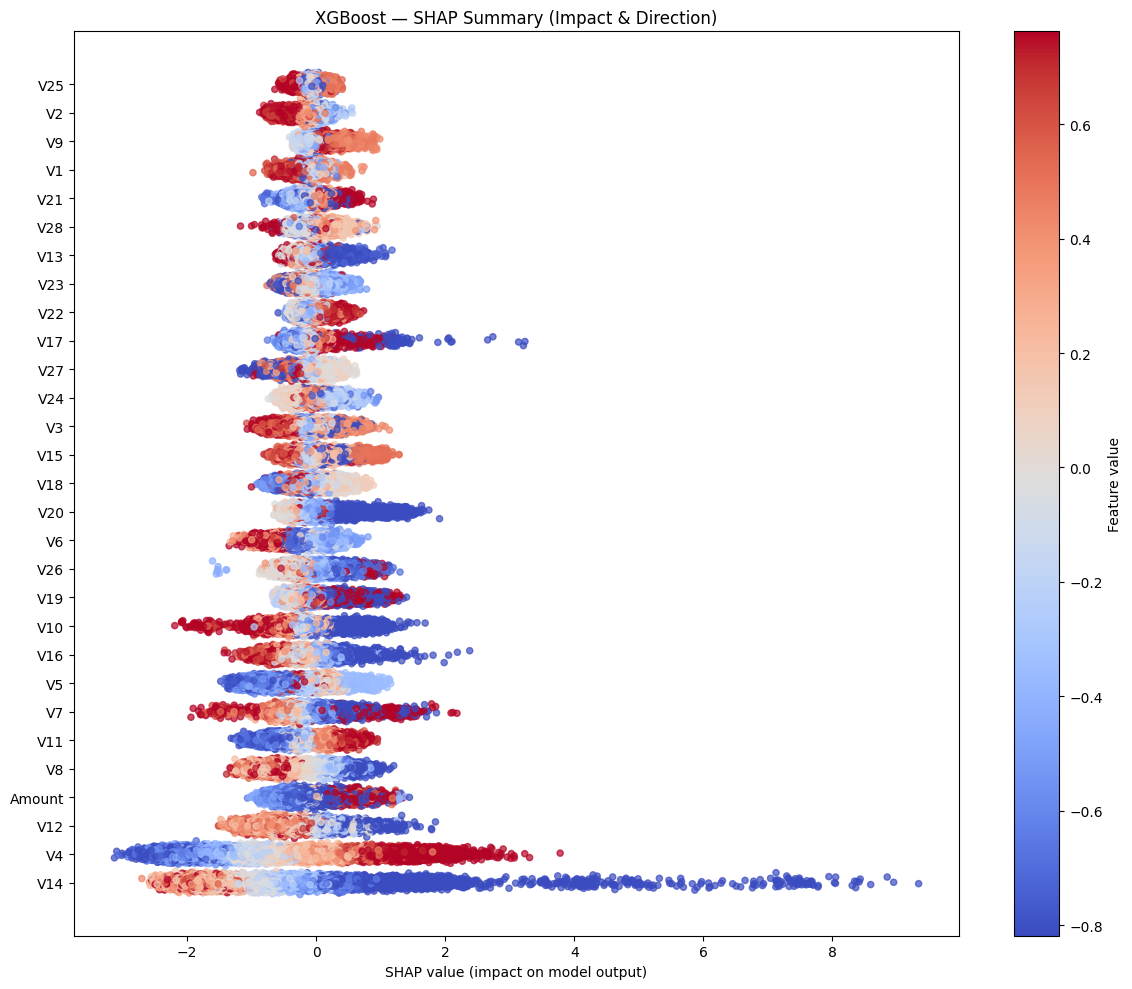

<Figure size 1200x800 with 0 Axes>

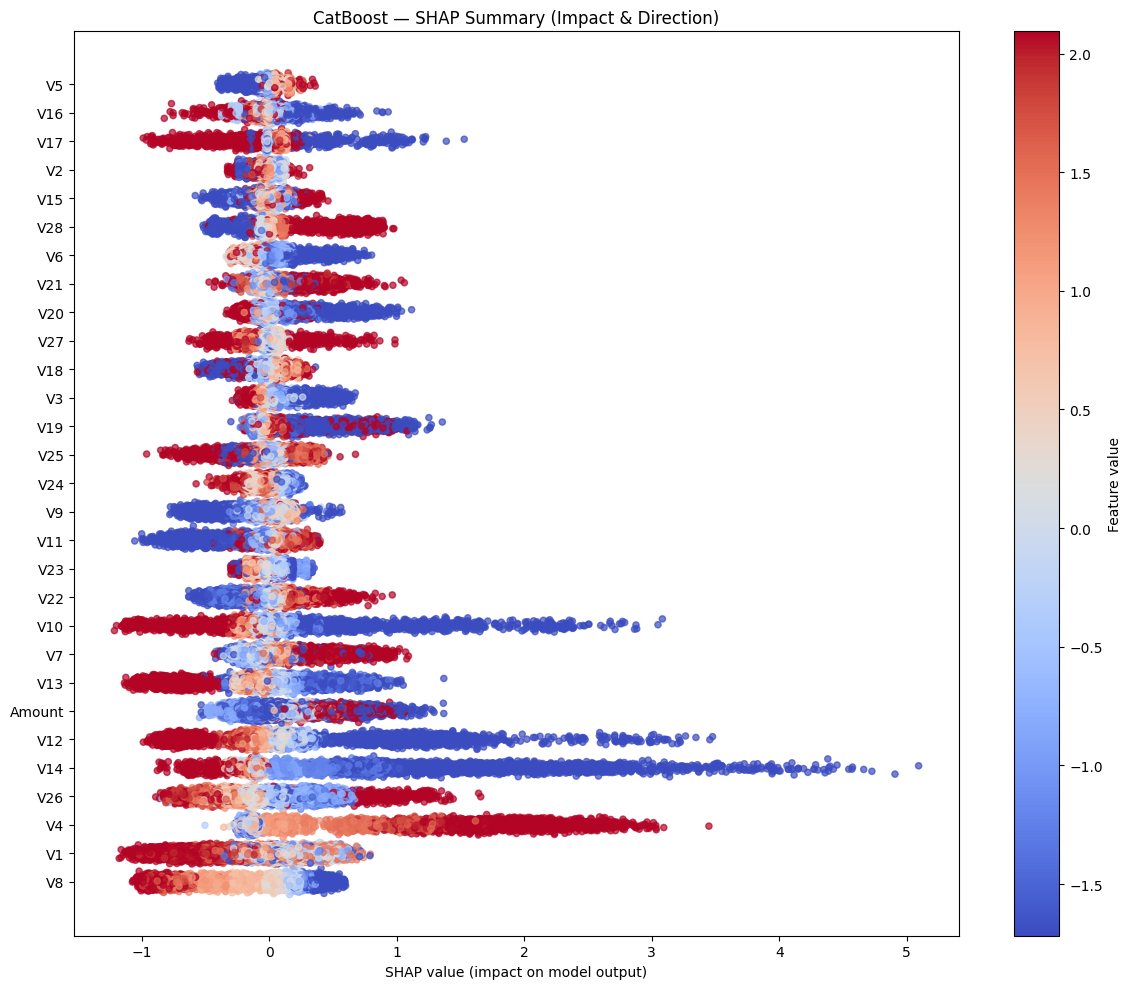


Top features for Random Forest: V14, V17, V12


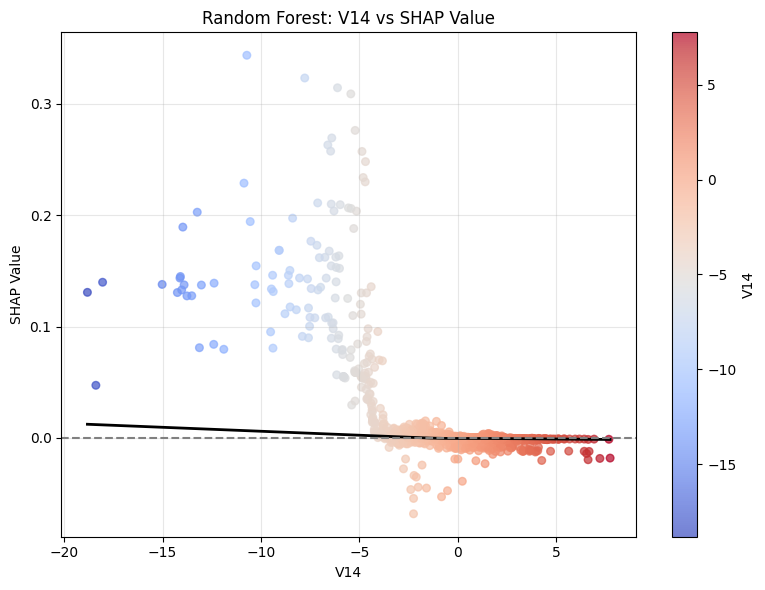

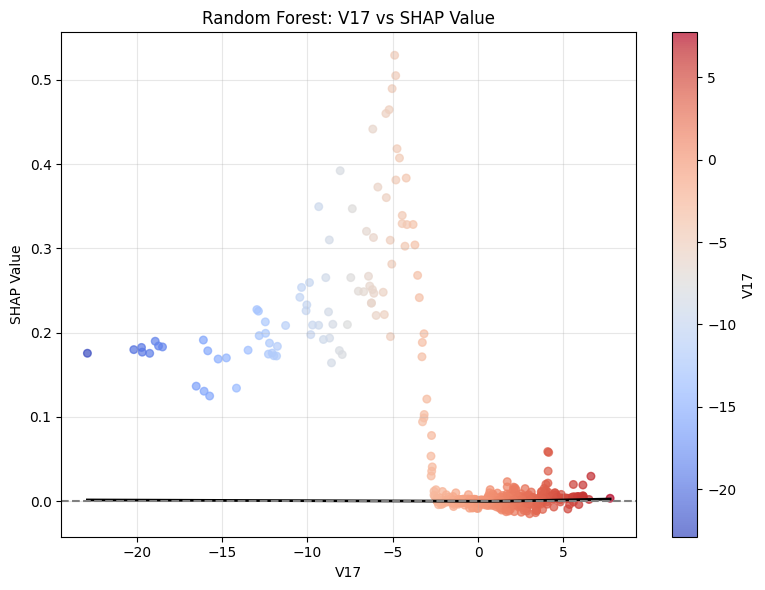

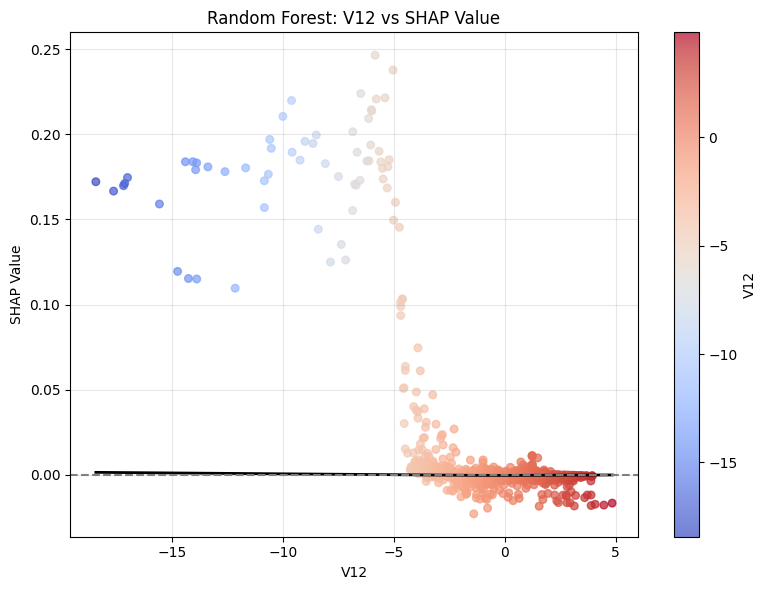


Top features for XGBoost: V14, V4, V12


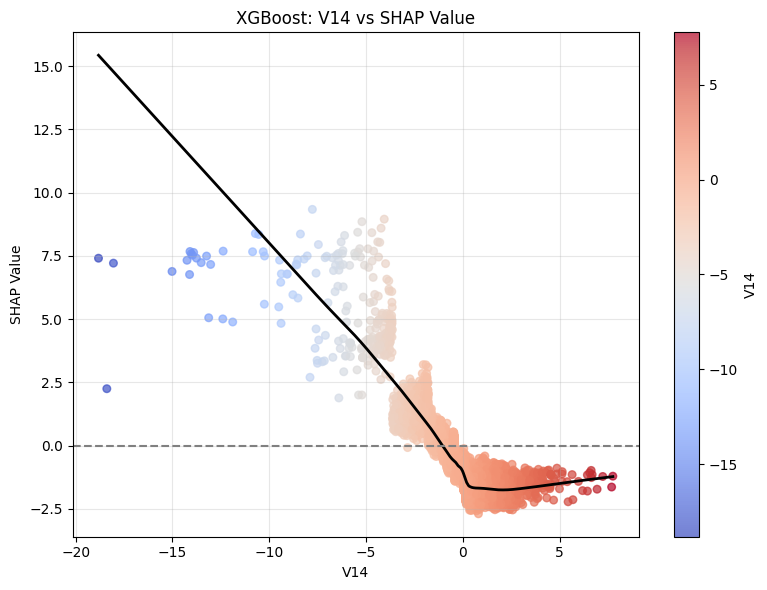

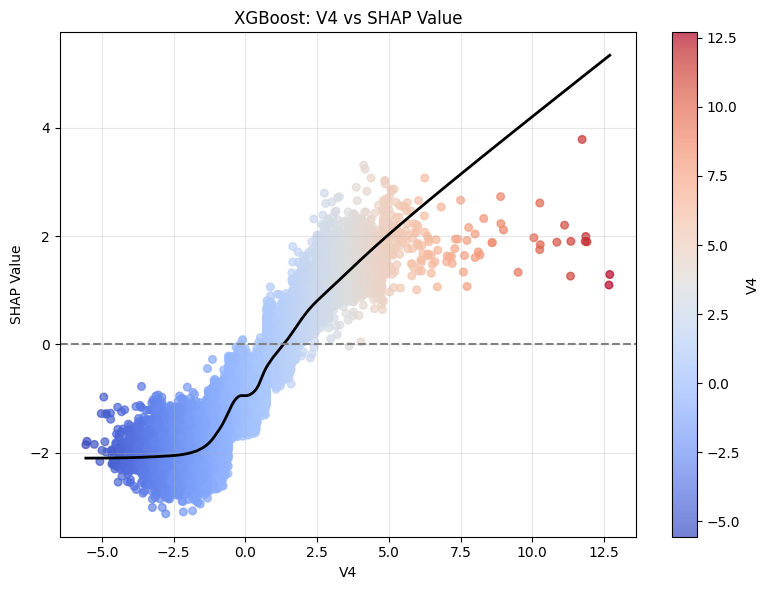

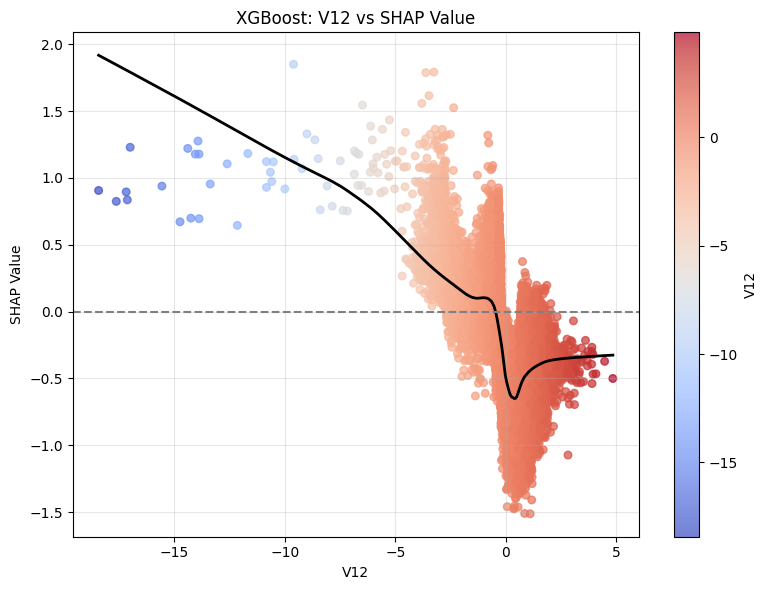


Top features for CatBoost: V8, V1, V4


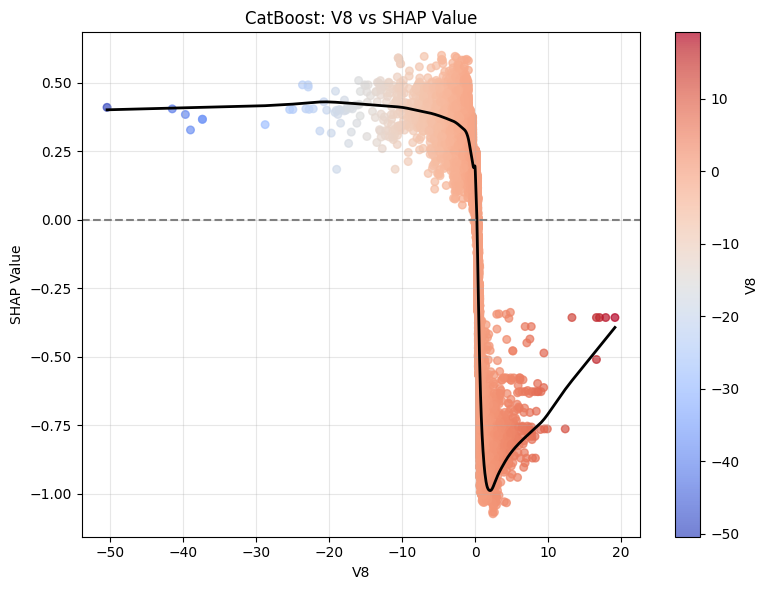

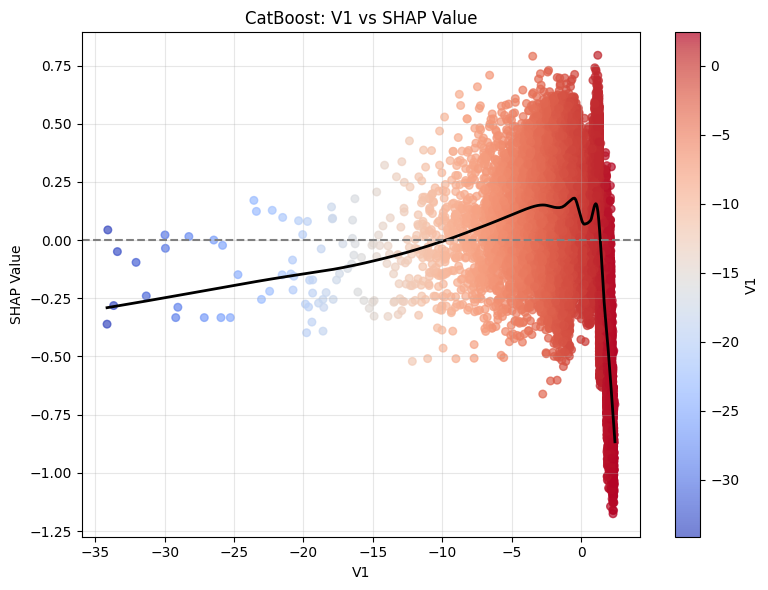

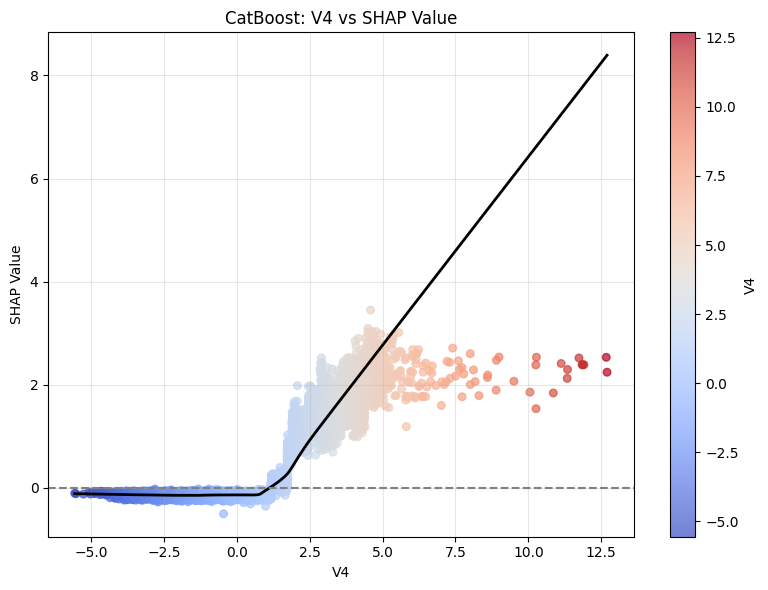

In [35]:
# Function to create proper SHAP summary plot showing direction of impact
def plot_shap_summary_with_direction(name, shap_values, X_test_df, feature_names):
    plt.figure(figsize=(12, 8))
    
    if name == 'Random Forest':
        # Random Forest has the correct structure already
        vals = shap_values[1]  # Class 1 values
        shap.summary_plot(
            vals, 
            X_test_df,
            feature_names=feature_names,
            plot_type='dot',
            show=False
        )
    else:
        # XGBoost and CatBoost need restructuring
        # We need to reshape the data to match what SHAP expects
        
        # For XGBoost and CatBoost, we have the full matrix of SHAP values
        # But we need to reshape it to work with shap.summary_plot
        
        # Create a manual SHAP-style summary plot
        feature_importance = np.mean(np.abs(shap_values), axis=0)
        sorted_idx = np.argsort(feature_importance)
        
        # Plot all features in descending order of importance
        plt.figure(figsize=(12, 10))
        
        # Create a scatter plot for each feature
        for i, idx in enumerate(reversed(sorted_idx)):
            # Get feature values and corresponding SHAP values
            feature_vals = X_test_df.iloc[:, idx].values
            shap_vals = shap_values[:, idx]
            
            # Use percentile-based color mapping like SHAP does
            percentiles = np.percentile(feature_vals, [5, 50, 95])
            norm = plt.Normalize(percentiles[0], percentiles[2])
            colors = plt.cm.coolwarm(norm(feature_vals))
            
            # Plot points with jitter for better visibility
            jitter = 0.1
            y_pos = i + np.random.normal(0, jitter, size=len(shap_vals))
            
            # Plot points
            plt.scatter(shap_vals, y_pos, c=colors, alpha=0.7, s=20)
        
        # Add feature names
        plt.yticks(range(len(sorted_idx)), [feature_names[idx] for idx in reversed(sorted_idx)])
        
        # Add color bar to show feature values
        sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm)
        cbar.set_label('Feature value')
    
    plt.title(f"{name} — SHAP Summary (Impact & Direction)")
    plt.xlabel('SHAP value (impact on model output)')
    plt.tight_layout()
    plt.show()

# Create the plots for each model
models = [
    ('Random Forest', shap_values['Random Forest']),
    ('XGBoost', shap_values['XGBoost']),
    ('CatBoost', shap_values['CatBoost'])
]

# Create SHAP summary plots with direction
for name, model_shap in models:
    try:
        plot_shap_summary_with_direction(name, model_shap, X_test_df, feature_names)
    except Exception as e:
        print(f"Error plotting {name}: {e}")
        
        # Alternative approach using manual visualization
        if name != 'Random Forest':
            plt.figure(figsize=(12, 10))
            
            # Sort features by importance
            feature_importance = np.mean(np.abs(model_shap), axis=0)
            sorted_idx = np.argsort(feature_importance)
            
            # Plot violin plot for each feature
            for i, idx in enumerate(reversed(sorted_idx)):
                # Get SHAP values for this feature
                shap_vals = model_shap[:, idx]
                
                # Create violin plot
                parts = plt.violinplot(shap_vals, [i], showmeans=True, showextrema=True)
                
                # Color positive values red, negative values blue
                for pc in parts['bodies']:
                    pc.set_facecolor('lightblue')
                    pc.set_edgecolor('black')
                    pc.set_alpha(0.7)
                
                # Add a scatter plot of SHAP values
                y_pos = i + np.random.normal(0, 0.05, size=len(shap_vals))
                plt.scatter(shap_vals, y_pos, c=shap_vals, cmap='coolwarm', 
                           alpha=0.5, s=5, vmin=-np.max(np.abs(shap_vals)), vmax=np.max(np.abs(shap_vals)))
            
            plt.yticks(range(len(sorted_idx)), [feature_names[idx] for idx in reversed(sorted_idx)])
            plt.xlabel('SHAP Value (impact on model output)')
            plt.title(f"{name} — SHAP Summary (Impact & Direction)")
            plt.axvline(x=0, color='gray', linestyle='--')
            plt.colorbar(label='SHAP Value')
            plt.tight_layout()
            plt.show()

# Create dependence plots for top features in each model
for name, model_shap in models:
    # Identify top features
    if name == 'Random Forest':
        vals = model_shap[1]
        feature_importance = np.mean(np.abs(vals), axis=0)
    else:
        feature_importance = np.mean(np.abs(model_shap), axis=0)
    
    # Get top 3 features
    top_indices = np.argsort(-feature_importance)[:3]
    top_features = [feature_names[i] for i in top_indices]
    
    print(f"\nTop features for {name}: {', '.join(top_features)}")
    
    # Create dependence plots for top features
    for feat_idx in top_indices:
        feat_name = feature_names[feat_idx]
        
        plt.figure(figsize=(8, 6))
        
        # Get feature values
        x_values = X_test_df.iloc[:, feat_idx].values
        
        # Get SHAP values for this feature
        if name == 'Random Forest':
            y_values = model_shap[1][:, feat_idx]
        else:
            y_values = model_shap[:, feat_idx]
        
        # Create scatter plot with color based on the feature value itself
        scatter = plt.scatter(x_values, y_values, 
                             c=x_values, cmap='coolwarm', 
                             alpha=0.7, s=30)
        
        # Add trend line
        from scipy import stats
        try:
            # Add LOWESS smoothing line
            from statsmodels.nonparametric.smoothers_lowess import lowess
            z = lowess(y_values, x_values, frac=0.3)
            plt.plot(z[:, 0], z[:, 1], 'k-', linewidth=2)
        except:
            # Fallback to linear trend
            slope, intercept, r_value, p_value, std_err = stats.linregress(x_values, y_values)
            x_sorted = np.sort(x_values)
            plt.plot(x_sorted, intercept + slope*x_sorted, 'k-', linewidth=2)
        
        plt.colorbar(scatter, label=feat_name)
        plt.xlabel(feat_name)
        plt.ylabel('SHAP Value')
        plt.title(f"{name}: {feat_name} vs SHAP Value")
        plt.grid(True, alpha=0.3)
        plt.axhline(y=0, color='gray', linestyle='--')
        plt.tight_layout()
        plt.show()

In [ ]:
 def create_stacked_model(X_train, y_train, X_test, y_test, use_existing_models=True):
    """
    Implements SHAP-guided stacking approach
    
    Parameters:
    -----------
    X_train, y_train: Training data
    X_test, y_test: Test data
    use_existing_models: Whether to use pre-trained models or train new ones
    
    Returns:
    --------
    Dictionary with performance metrics and stacked model
    """
    
    # Define the base models and their feature subsets
    rf_features = ['V14', 'V17', 'V12', 'V4', 'V10', 'V1']
    xgb_features = ['V14', 'V4', 'V12', 'V8', 'Amount']  
    cb_features = ['V14', 'V4', 'V12', 'V1', 'V8', 'V26', 'V27'] 
    
    if use_existing_models:
        # Use existing pre-trained models
        rf_model = rf_model_pretrained  # Your pre-trained Random Forest
        xgb_model = xgb_model_pretrained  # Your pre-trained XGBoost
        cb_model = cb_model_pretrained  # Your pre-trained CatBoost
        
        # Create new meta-model
        meta_model = LogisticRegression(max_iter=1000, class_weight='balanced')
        
        # Generate meta-features from existing models
        meta_features_train = create_meta_features(
            X_train, 
            [(rf_model, rf_features), (xgb_model, xgb_features), (cb_model, cb_features)]
        )
        
        # Train meta-model
        meta_model.fit(meta_features_train, y_train)
        
        # Generate meta-features for test set
        meta_features_test = create_meta_features(
            X_test, 
            [(rf_model, rf_features), (xgb_model, xgb_features), (cb_model, cb_features)]
        )
        
    else:
        # Train new models and implement stacking with cross-validation
        # This is the recommended approach as it avoids information leakage
        
        # Define cross-validation strategy
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        # Initialize models with their optimal hyperparameters
        rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
        xgb_model = XGBClassifier(learning_rate=0.01, n_estimators=100, random_state=42)
        cb_model = CatBoostClassifier(iterations=100, random_state=42, verbose=False)
        
        # Create out-of-fold predictions with cross-validation
        meta_features_train = np.zeros((X_train.shape[0], 3))  # Base predictions
        
        # Store models trained on full training data
        final_models = []
        
        # Create out-of-fold predictions
        for i, (model, features) in enumerate([
                (rf_model, rf_features), 
                (xgb_model, xgb_features), 
                (cb_model, cb_features)
            ]):
            
            # Get out-of-fold predictions for this model
            oofs = cross_val_predict(
                model, X_train[features], y_train, 
                cv=cv, method='predict_proba'
            )[:, 1]
            
            # Store OOF predictions
            meta_features_train[:, i] = oofs
            
            # Train model on full training data for later test predictions
            model_clone = clone(model)
            model_clone.fit(X_train[features], y_train)
            final_models.append((model_clone, features))
            
        # Train meta-model on out-of-fold predictions
        meta_model = LogisticRegression(max_iter=1000, class_weight='balanced')
        meta_model.fit(meta_features_train, y_train)
        
        # Generate meta-features for test set using models trained on full data
        meta_features_test = create_meta_features(X_test, final_models)
    
    # Evaluate performance
    meta_predictions = meta_model.predict_proba(meta_features_test)[:, 1]
    performance = evaluate_model(meta_predictions, y_test)
    
    return {
        'stacked_model': (meta_model, final_models if not use_existing_models else None),
        'performance': performance,
        'meta_features_test': meta_features_test,
        'predictions': meta_predictions
    }

create_stacked_model(X_train_array, y_train_array, X_test_array, y_test_array, use_existing_models=True)